#  Analyse spectra holo at AuxTel for Configurations

- version 3 to work with results of postisrccd from usdf


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- Spectractor version 2.3, version of December 2022
- creation date : December 9th  2022
- last update : December 9th 2022


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

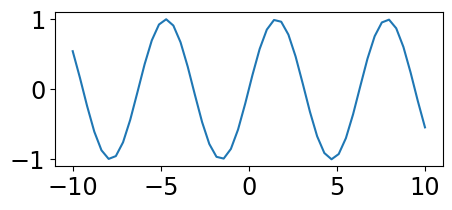

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-12-11'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.17.0'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters,dumpfitparameters
from spectractor.extractor.spectrum import Spectrum, detect_lines, calibrate_spectrum
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA ,O2_1, O2_2, O2B,H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [12]:
from time import sleep

In [13]:
from astropy.time import Time
import astropy.units as u

In [14]:
import pickle

# Calibration line

In [15]:
ATMOSPHERIC_LINES_CALIB = [O2B,O2_1, O2_2]
HYDROGEN_LINES_CALIB = [HALPHA, HBETA, HGAMMA, HDELTA]

setatml = set(ATMOSPHERIC_LINES_CALIB)
sethdryl = set(HYDROGEN_LINES_CALIB )

LINES_CALIB = list(sethdryl.union(setatml))

lines_calib = Lines(LINES_CALIB , hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)

# Function

In [16]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [17]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [18]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [19]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [20]:
# path index for each month
DATE="20221207"
#DATE="20211104"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"
FLAG_RECALIB = False

In [21]:
version="v6.0"

In [22]:
#Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1D_BG40.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF1DTRUNC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFMvNov2022.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFMvNov2022b.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFMREBIN2vDec2022.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFMvDec2022.ini']

config_idx = len(list_of_spectractorconfigfiles)-1
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [23]:
configdir 

'config_DECONVOLUTION_FFMvDec2022'

In [24]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_FFMvDec2022.ini


In [25]:
load_config(configfilename)

In [26]:
configmode = list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_DECONVOLUTION_")[-1].split(".") [0]
configmode

'FFMvDec2022'

## Parameters

In [27]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 4096
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.0952
CCD_PIXEL2MM 0.01
CCD_REBIN 1
CONFIG_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/Spectractor-2.3-py3.9.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /sps/lsst/groups/auxtel/softs/utils/anaconda3_nov2022/lib/python3.9/site-packages/Spectractor-2.3-py3.9.egg/spectractor/extractor/dispersers/
DISPLAY True
DISTANCE2CCD 181
DISTANCE2CCD_ERR 0.4
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_

# Path

In [28]:
HOSTCC=True
LAPTOP=False

In [29]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2023/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode)

else:
    if not LAPTOP:
        path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2023/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode)
    else:
        path_auxtel="/Users/dagoret/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2023/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode)
        


In [30]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207'

In [31]:
! ls -l $path_output_spectractor

total 0
drwxrws--- 1 dagoret lsst 2 Dec  9 15:35 2022120700357
drwxrws--- 1 dagoret lsst 2 Dec  9 15:34 2022120700361
drwxrws--- 1 dagoret lsst 2 Dec  9 20:59 2022120700362
drwxrws--- 1 dagoret lsst 2 Dec  9 15:34 2022120700366
drwxrws--- 1 dagoret lsst 2 Dec  9 17:46 2022120700367
drwxrws--- 1 dagoret lsst 2 Dec  9 15:09 2022120700371
drwxrws--- 1 dagoret lsst 2 Dec  9 15:31 2022120700372
drwxrws--- 1 dagoret lsst 2 Dec  9 14:56 2022120700376
drwxrws--- 1 dagoret lsst 2 Dec  9 16:24 2022120700377
drwxrws--- 1 dagoret lsst 2 Dec  9 15:58 2022120700381
drwxrws--- 1 dagoret lsst 2 Dec  9 17:55 2022120700382
drwxrws--- 1 dagoret lsst 2 Dec  9 20:13 2022120700391
drwxrws--- 1 dagoret lsst 2 Dec  9 19:03 2022120700392
drwxrws--- 1 dagoret lsst 2 Dec  9 15:15 2022120700401
drwxrws--- 1 dagoret lsst 2 Dec  9 16:24 2022120700402
drwxrws--- 1 dagoret lsst 2 Dec  9 20:21 2022120700406
drwxrws--- 1 dagoret lsst 2 Dec  9 17:21 2022120700407
drwxrws--- 1 dagoret lsst 2 Dec  9 15:30 2022120700411
dr

In [32]:
# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
#config=os.path.join("./config",configfilename)
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_FFMvDec2022.ini


In [33]:
load_config(configfilename)

## Logbook for file selection

In [34]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [35]:
df=pd.read_csv(filename_logbook,index_col=0)

In [36]:
pd.set_option('display.max_rows', None)

In [37]:
df

index                     date  \
0       0  2022-12-08T04:21:39.848   
1       1  2022-12-08T04:24:19.011   
2       2  2022-12-08T04:25:01.980   
3       3  2022-12-08T04:27:21.436   
4       4  2022-12-08T04:28:04.366   
5       5  2022-12-08T04:30:21.301   
6       6  2022-12-08T04:31:04.229   
7       7  2022-12-08T04:43:49.617   
8       8  2022-12-08T04:44:32.479   
9       9  2022-12-08T04:46:52.811   
10     10  2022-12-08T04:47:35.637   
11     11  2022-12-08T04:49:46.567   
12     12  2022-12-08T04:50:29.491   
13     13  2022-12-08T04:52:34.821   
14     14  2022-12-08T04:53:17.731   
15     15  2022-12-08T04:55:24.956   
16     16  2022-12-08T04:56:07.871   
17     17  2022-12-08T04:58:28.693   
18     18  2022-12-08T04:59:11.543   
19     19  2022-12-08T05:03:46.366   
20     20  2022-12-08T05:04:29.292   
21     21  2022-12-08T05:06:40.708   
22     22  2022-12-08T05:07:23.526   
23     23  2022-12-08T05:09:46.688   
24     24  2022-12-08T05:10:29.590   
25     25  2022-12-08T05:14:41.705   
26     26  2022-12-08T05:15:24.652   
27     27  2022-12-08T05:17:12.634   
28     28  2022-12-08T05:17:55.446   
29     29  2022-12-08T05:20:20.341   
30     30  2022-12-08T05:21:03.250   
31     31  2022-12-08T05:23:14.612   
32     32  2022-12-08T05:23:57.437   
33     33  2022-12-08T05:26:08.549   
34     34  2022-12-08T05:26:51.588   
35     35  2022-12-08T05:29:06.753   
36     36  2022-12-08T05:29:49.707   
37     37  2022-12-08T05:32:25.111   
38     38  2022-12-08T05:33:08.052   
39     39  2022-12-08T05:35:23.660   
40     40  2022-12-08T05:36:06.693   
41     41  2022-12-08T05:38:34.083   
42     42  2022-12-08T05:39:16.996   

                                                 path  \
0   /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
1   /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
2   /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
3   /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
4   /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
5   /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
6   /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
7   /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
8   /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
9   /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
10  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
11  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
12  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
13  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
14  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
15  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
16  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
17  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
18  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
19  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
20  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
21  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
22  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
23  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
24  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
25  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
26  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
27  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
28  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
29  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
30  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
31  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
32  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
33  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
34  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
35  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
36  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
37  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
38  /sps/lsst/groups/auxtel/data/2023/empty~holo4_...   
39  /sps/lsst/groups/auxtel/data/2023/empty~holo4_.

## Selection of input files

In [38]:
df_good=df
df_good["quality"] = 1

In [39]:
for spectra_file in df_good["file"]:
    print(spectra_file)

exposure_2022120700357_postisrccd.fits
exposure_2022120700361_postisrccd.fits
exposure_2022120700362_postisrccd.fits
exposure_2022120700366_postisrccd.fits
exposure_2022120700367_postisrccd.fits
exposure_2022120700371_postisrccd.fits
exposure_2022120700372_postisrccd.fits
exposure_2022120700376_postisrccd.fits
exposure_2022120700377_postisrccd.fits
exposure_2022120700381_postisrccd.fits
exposure_2022120700382_postisrccd.fits
exposure_2022120700386_postisrccd.fits
exposure_2022120700387_postisrccd.fits
exposure_2022120700391_postisrccd.fits
exposure_2022120700392_postisrccd.fits
exposure_2022120700396_postisrccd.fits
exposure_2022120700397_postisrccd.fits
exposure_2022120700401_postisrccd.fits
exposure_2022120700402_postisrccd.fits
exposure_2022120700406_postisrccd.fits
exposure_2022120700407_postisrccd.fits
exposure_2022120700411_postisrccd.fits
exposure_2022120700412_postisrccd.fits
exposure_2022120700416_postisrccd.fits
exposure_2022120700417_postisrccd.fits
exposure_2022120700421_po

## Selection of Spectractor output files

In [40]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [41]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


print("list of subdir found ",list_of_files)

for subdir in list_of_files:
    
    
    #tag = file_tag_forsorting(subdir)
    tag = subdir_tag_forsorting(subdir)
    
        
    print(tag)    
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
  
    
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=subdir_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        #targetname=file_target(subdir)
        #print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)



print("-----------------------------------------------------------------")


#LISTNUM=sorted(LISTNUM)
#LISTNUMNODIR=sorted(LISTNUMNODIR)
#LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
#LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
#LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


list of subdir found  ['2022120700357', '2022120700361', '2022120700362', '2022120700366', '2022120700367', '2022120700371', '2022120700372', '2022120700376', '2022120700377', '2022120700381', '2022120700382', '2022120700391', '2022120700392', '2022120700401', '2022120700402', '2022120700406', '2022120700407', '2022120700411', '2022120700412', '2022120700421', '2022120700422', '2022120700426', '2022120700427', '2022120700431', '2022120700432', '2022120700447', '2022120700448', '2022120700458', '2022120700459', '2022120700463']
00357
---------------------------------------------
2022120700357  	   00357
2022120700357 is a directory
tagname= 00357
dir_plots is not empty
dir_spectration is not empty
00361
---------------------------------------------
2022120700361  	   00361
2022120700361 is a directory
tagname= 00361
dir_plots is not empty
dir_spectration is not empty
00362
---------------------------------------------
2022120700362  	   00362
2022120700362 is a directory
tagname= 00362


In [42]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700357/basespec', '/sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700361/basespec', '/sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700362/basespec', '/sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700366/basespec', '/sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700367/basespec', '/sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700371/basespec', '/sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/2022

In [43]:
config

'./config/auxtel_config_holo_DECONVOLUTION_FFMvDec2022.ini'

## Extraction of spectra

In [44]:
all_files_spectra = []
#all_files_spectrogram = []
all_files_lines = []
#all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            #the_file_spectrogram=the_file_spectrum.replace("_spectrum.fits","_spectrogram.fits")
            #all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            #the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            #all_files_table.append(the_file_table)
    

In [45]:
#all_files_spectrogram

In [46]:
all_files_spectra[:3]

['/sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700357/basespec/exposure_2022120700357_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700361/basespec/exposure_2022120700361_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700362/basespec/exposure_2022120700362_postisrccd_spectrum.fits']

In [47]:
#all_files_spectrogram[:3]

In [48]:
all_files_lines[:3]

['/sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700357/basespec/exposure_2022120700357_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700361/basespec/exposure_2022120700361_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700362/basespec/exposure_2022120700362_postisrccd_lines.csv']

In [49]:
#all_files_table[:3] 

## Selection of good spectra

In [50]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [51]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

## One Spectrum

0 ) exposure_2022120700357_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700357/basespec/exposure_2022120700357_postisrccd_spectrum.fits


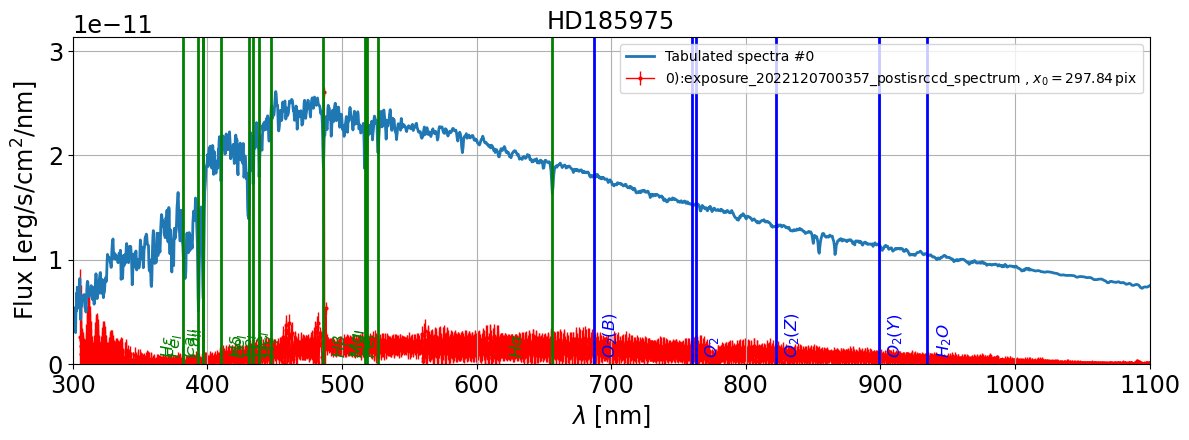

In [52]:
idx=0


fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])

    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
label = str(idx) +"):"+label
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True,label=label)

   
if FLAG_RECALIB: 
    parameters.DEBUG=True
    parameters.LIVE_FIT=True
    ax2 = fig.add_subplot(3, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    newlambdas = calibrate_spectrum(s, with_adr=True)
    label=str(idx) +"):"+filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
    
    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(newlambdas,s.data,"r-")
    s.lines.plot_detected_lines(ax=ax3)
    s.lines.plot_atomic_lines(ax=ax3,force=True)
    ax3.set_xlim(parameters.LAMBDA_MIN, parameters.LAMBDA_MAX)
    ax3.grid()
    
    

plt.show()
    

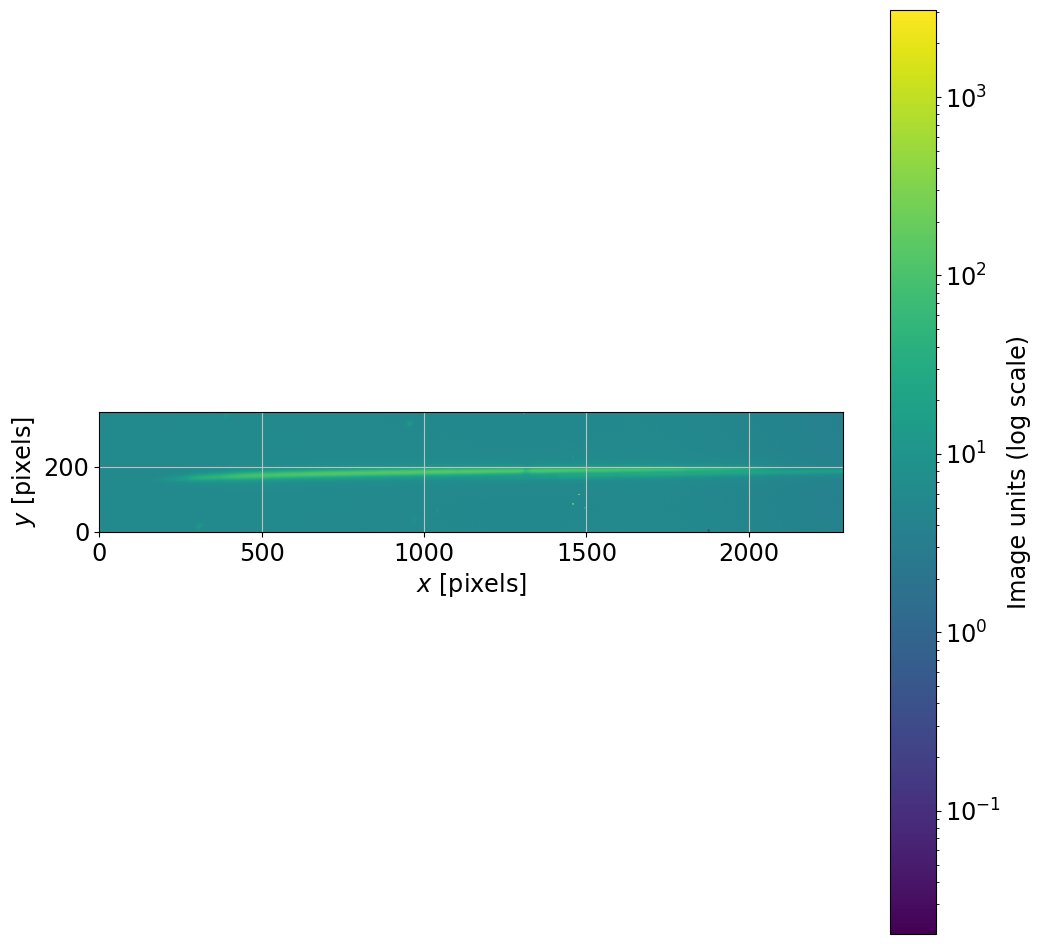

In [53]:
fig=plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)
#fullfilename2=all_files_spectrogram[idx]
#s.load_spectrogram(fullfilename2)
s.plot_spectrogram(ax=ax,scale="log")

In [54]:
parameters.REBIN=1

In [55]:
parameters.DEBUG=False
parameters.LIVE_FIT=False

## All Spectra

============================ 0 ) exposure_2022120700357_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700357/basespec/exposure_2022120700357_postisrccd_spectrum.fits ==============================


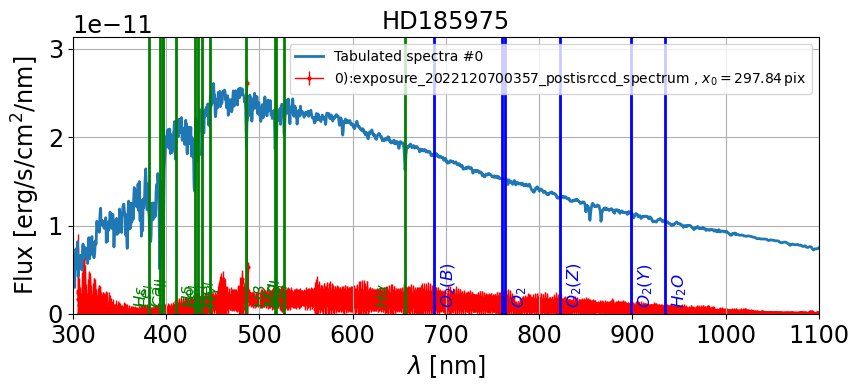

============================ 1 ) exposure_2022120700361_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700361/basespec/exposure_2022120700361_postisrccd_spectrum.fits ==============================


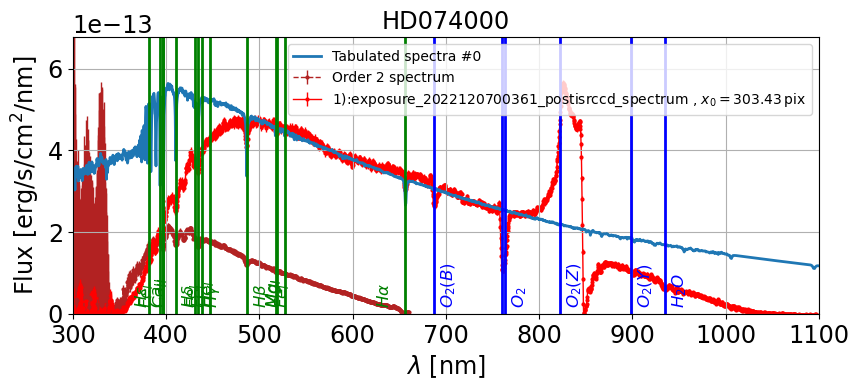

============================ 2 ) exposure_2022120700362_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700362/basespec/exposure_2022120700362_postisrccd_spectrum.fits ==============================


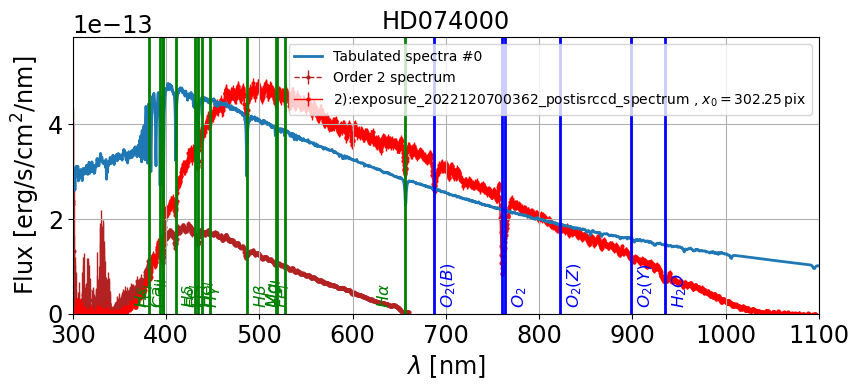

============================ 3 ) exposure_2022120700366_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700366/basespec/exposure_2022120700366_postisrccd_spectrum.fits ==============================


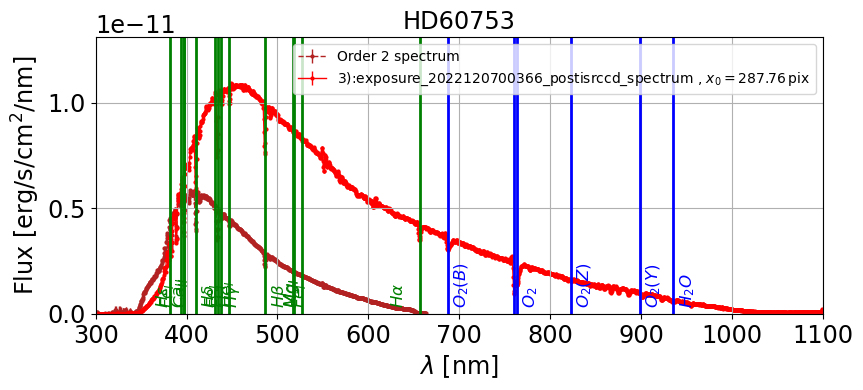

============================ 4 ) exposure_2022120700367_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700367/basespec/exposure_2022120700367_postisrccd_spectrum.fits ==============================


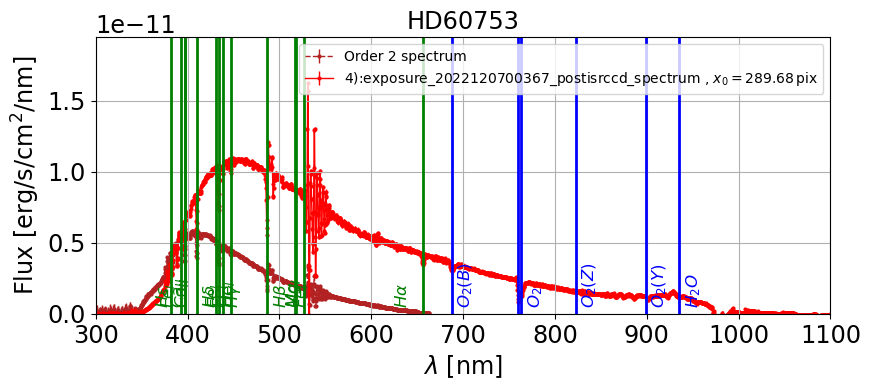

============================ 5 ) exposure_2022120700371_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700371/basespec/exposure_2022120700371_postisrccd_spectrum.fits ==============================


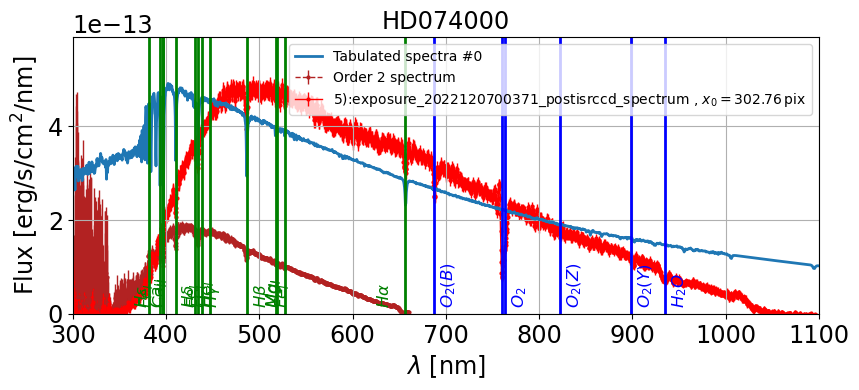

============================ 6 ) exposure_2022120700372_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700372/basespec/exposure_2022120700372_postisrccd_spectrum.fits ==============================


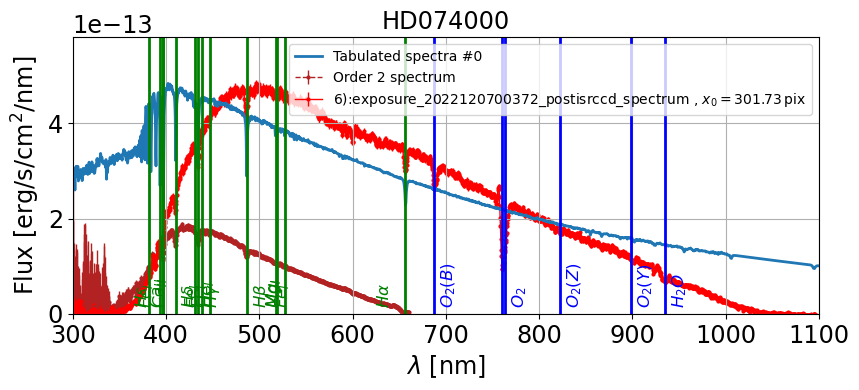

============================ 7 ) exposure_2022120700376_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700376/basespec/exposure_2022120700376_postisrccd_spectrum.fits ==============================


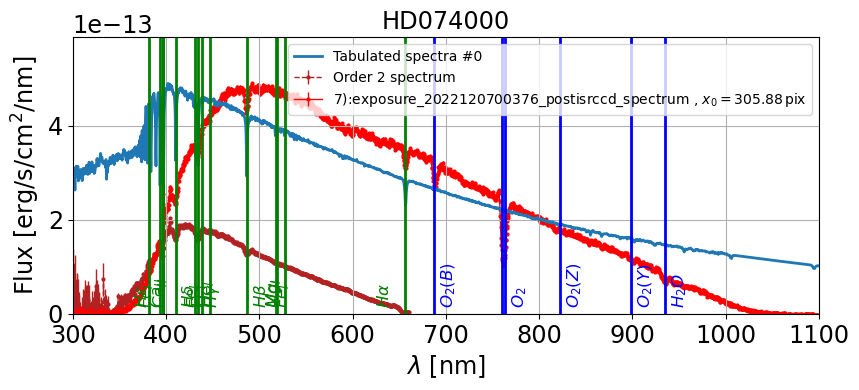

============================ 8 ) exposure_2022120700377_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700377/basespec/exposure_2022120700377_postisrccd_spectrum.fits ==============================


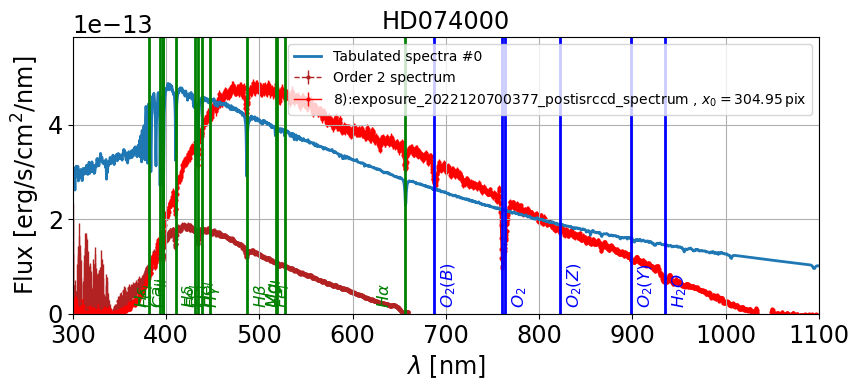

============================ 9 ) exposure_2022120700381_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700381/basespec/exposure_2022120700381_postisrccd_spectrum.fits ==============================


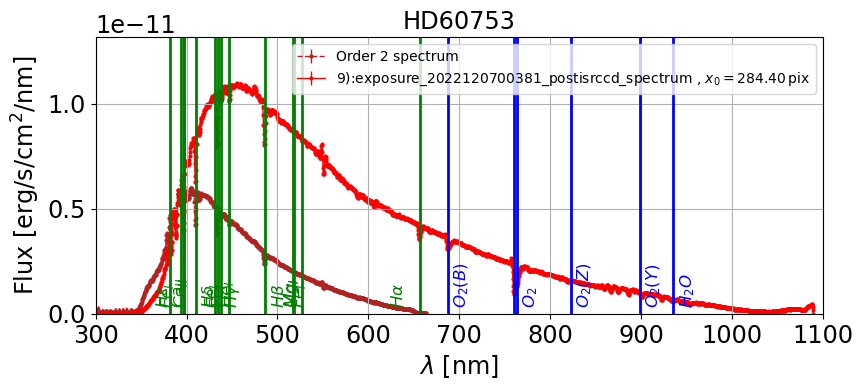

============================ 10 ) exposure_2022120700382_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700382/basespec/exposure_2022120700382_postisrccd_spectrum.fits ==============================


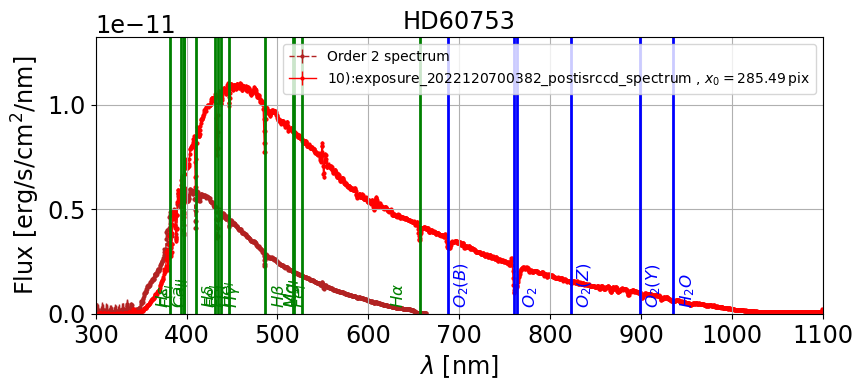

============================ 11 ) exposure_2022120700391_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700391/basespec/exposure_2022120700391_postisrccd_spectrum.fits ==============================


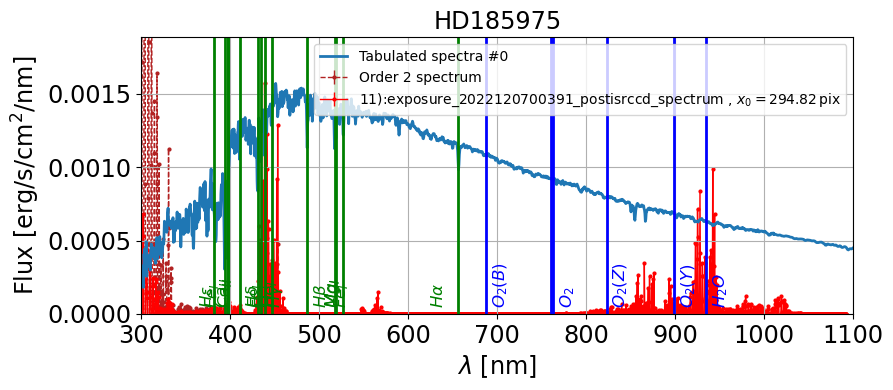

============================ 12 ) exposure_2022120700392_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700392/basespec/exposure_2022120700392_postisrccd_spectrum.fits ==============================


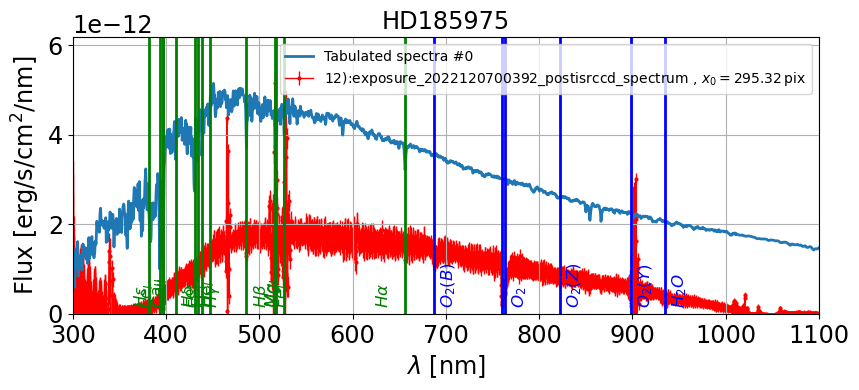

============================ 13 ) exposure_2022120700401_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700401/basespec/exposure_2022120700401_postisrccd_spectrum.fits ==============================


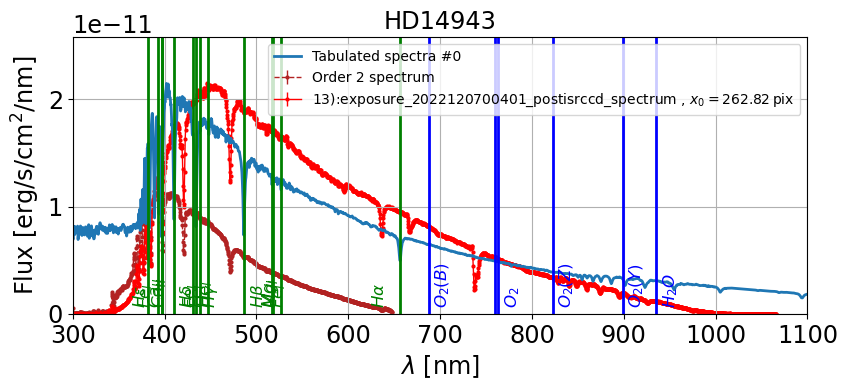

============================ 14 ) exposure_2022120700402_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700402/basespec/exposure_2022120700402_postisrccd_spectrum.fits ==============================


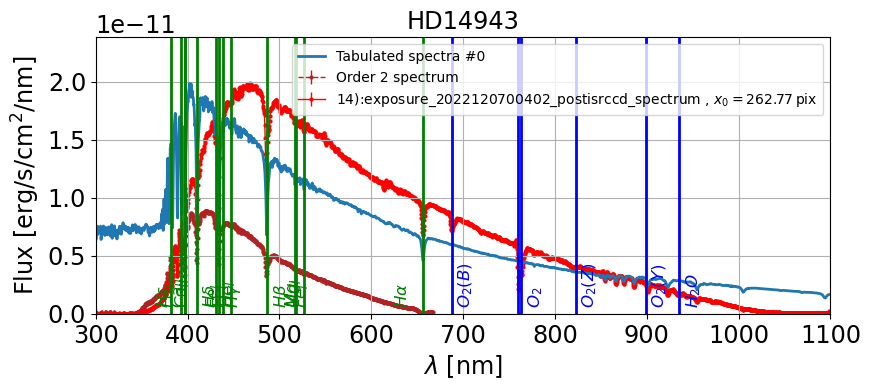

============================ 15 ) exposure_2022120700406_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700406/basespec/exposure_2022120700406_postisrccd_spectrum.fits ==============================


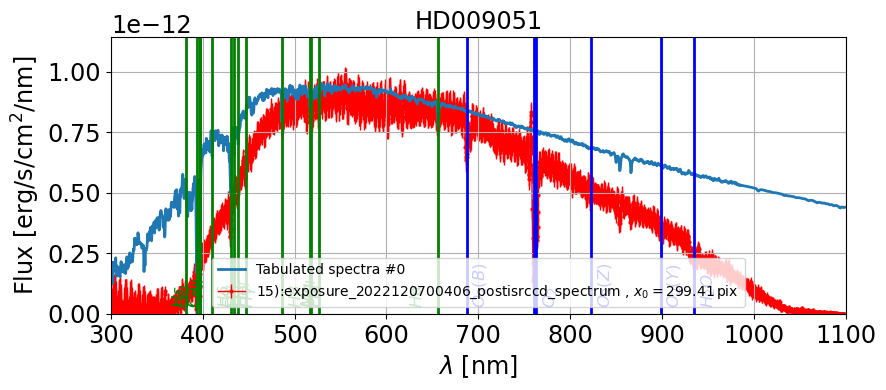

============================ 16 ) exposure_2022120700407_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700407/basespec/exposure_2022120700407_postisrccd_spectrum.fits ==============================


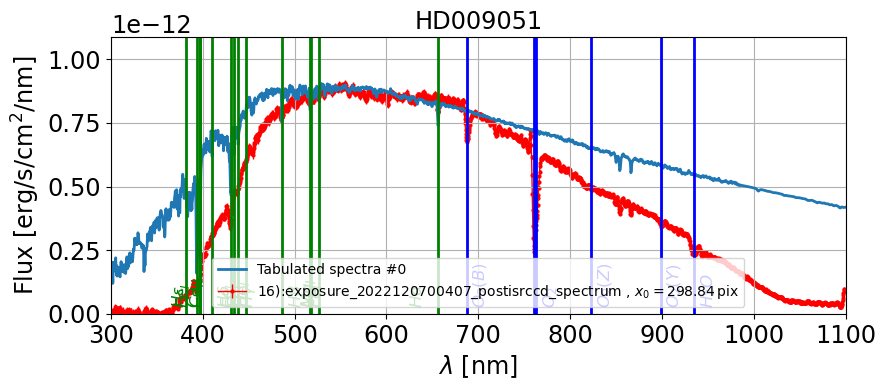

============================ 17 ) exposure_2022120700411_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700411/basespec/exposure_2022120700411_postisrccd_spectrum.fits ==============================


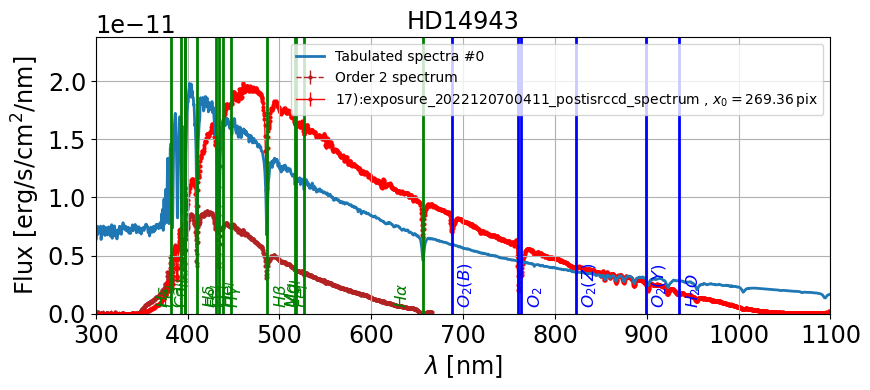

============================ 18 ) exposure_2022120700412_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700412/basespec/exposure_2022120700412_postisrccd_spectrum.fits ==============================


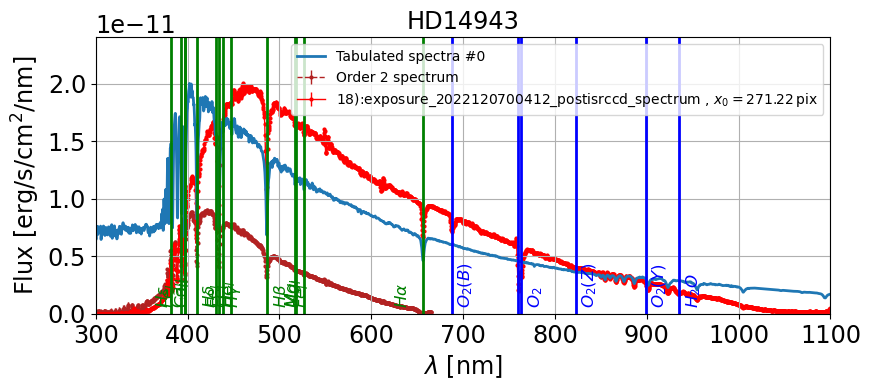

============================ 19 ) exposure_2022120700421_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700421/basespec/exposure_2022120700421_postisrccd_spectrum.fits ==============================


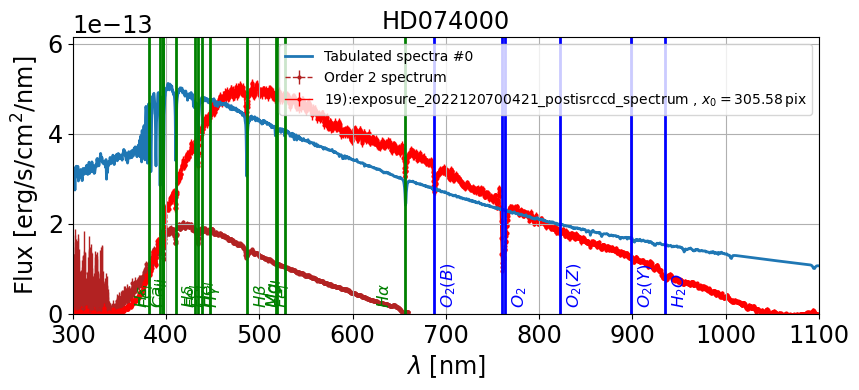

============================ 20 ) exposure_2022120700422_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700422/basespec/exposure_2022120700422_postisrccd_spectrum.fits ==============================


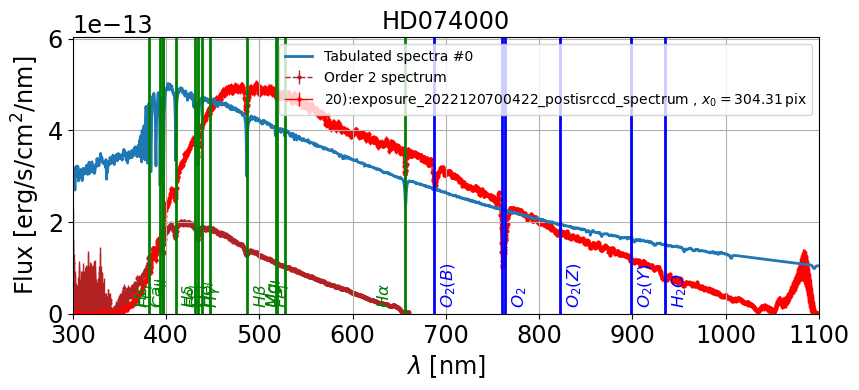

============================ 21 ) exposure_2022120700426_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700426/basespec/exposure_2022120700426_postisrccd_spectrum.fits ==============================


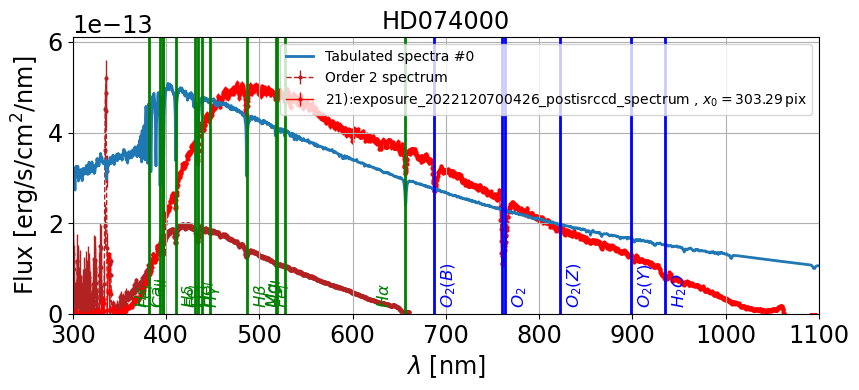

============================ 22 ) exposure_2022120700427_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700427/basespec/exposure_2022120700427_postisrccd_spectrum.fits ==============================


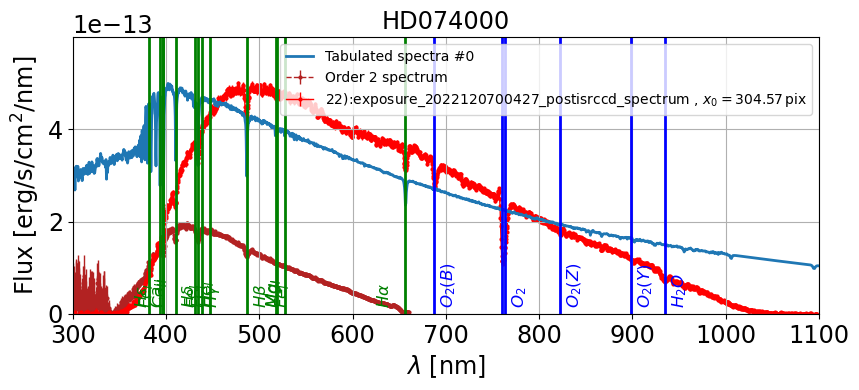

============================ 23 ) exposure_2022120700431_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700431/basespec/exposure_2022120700431_postisrccd_spectrum.fits ==============================


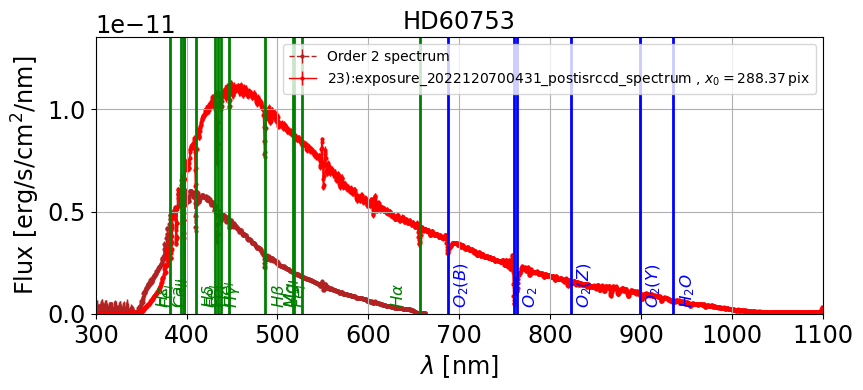

============================ 24 ) exposure_2022120700432_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700432/basespec/exposure_2022120700432_postisrccd_spectrum.fits ==============================


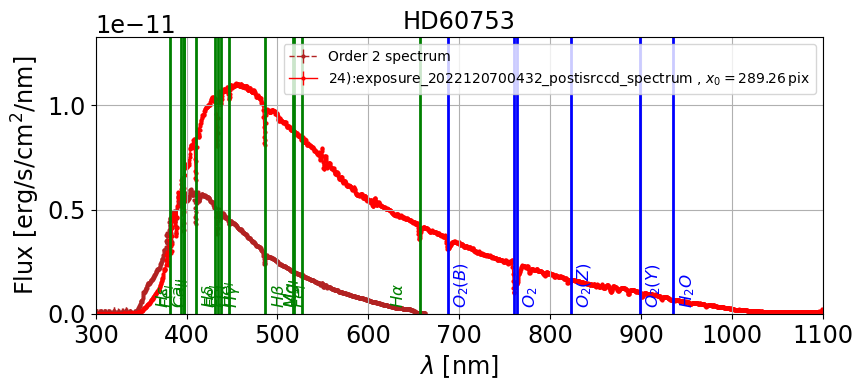

============================ 25 ) exposure_2022120700447_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700447/basespec/exposure_2022120700447_postisrccd_spectrum.fits ==============================


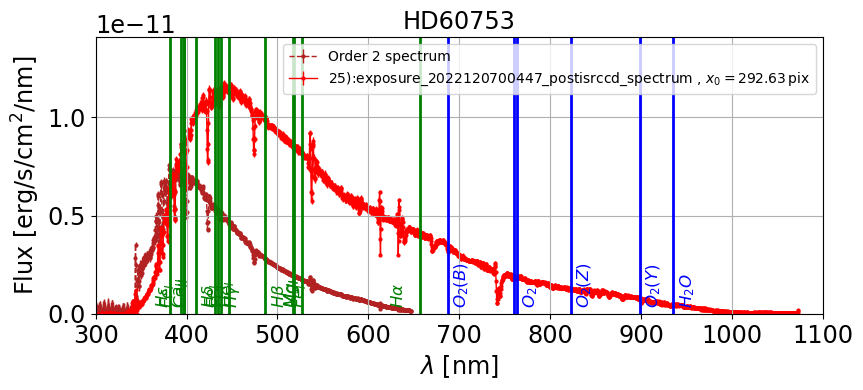

============================ 26 ) exposure_2022120700448_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700448/basespec/exposure_2022120700448_postisrccd_spectrum.fits ==============================


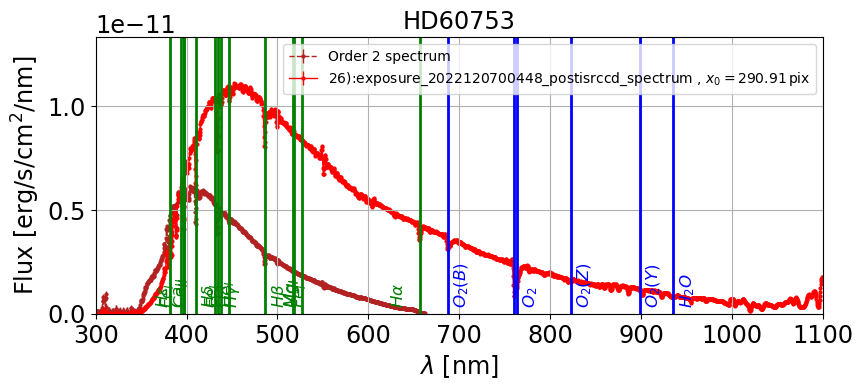

============================ 27 ) exposure_2022120700458_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700458/basespec/exposure_2022120700458_postisrccd_spectrum.fits ==============================


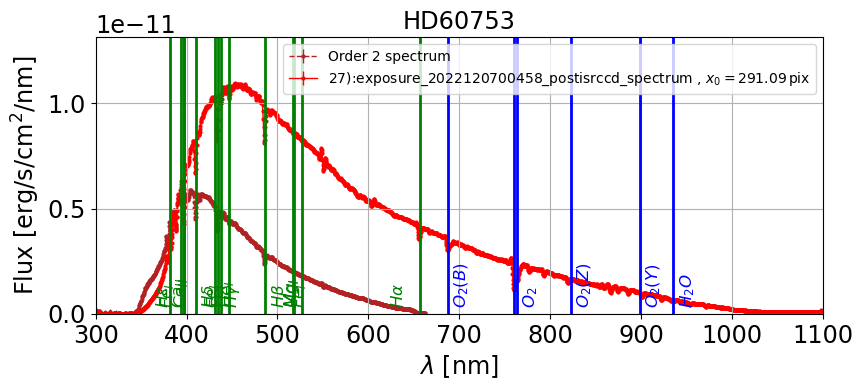

============================ 28 ) exposure_2022120700459_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700459/basespec/exposure_2022120700459_postisrccd_spectrum.fits ==============================


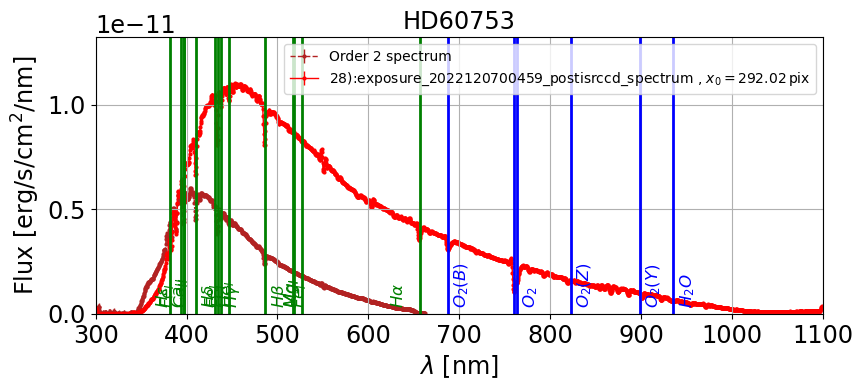

============================ 29 ) exposure_2022120700463_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700463/basespec/exposure_2022120700463_postisrccd_spectrum.fits ==============================


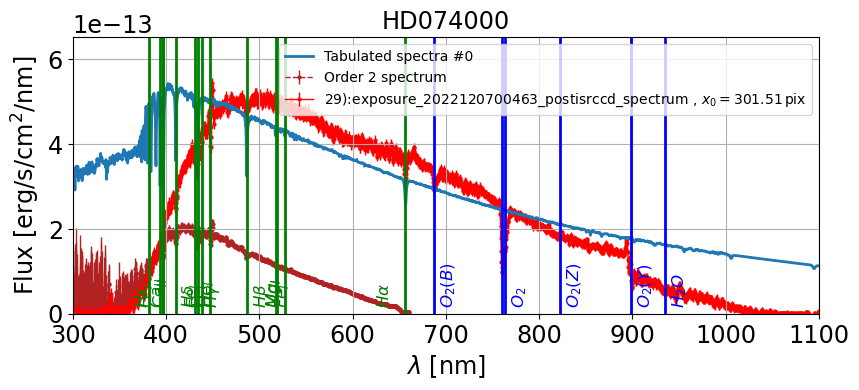

In [56]:
parameters.DISPLAY=True

FLAG_ORDER2 = False

infos = []
all_lambdas=[]
all_data=[]
all_data_err=[]

if FLAG_ORDER2:
    all_lambdas_order2=[]
    all_data_order2=[]
    all_data_err_order2=[]

all_num=[]
all_figs = []


idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename = os.path.basename(fullfilename)
    print("============================",idx,")",filename," ",fullfilename,"==============================")
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    
   
     
    s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    label = str(idx) +"):"+label
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    #print("=== ORIGINAL CALIB lines === ")
    #s.lines.print_detected_lines(print_table=True)
    
    
    
    
    if FLAG_RECALIB: 
        print(" === RECALIBRATE lines === ")
        s.lines = lines_calib
        lambdas = calibrate_spectrum(s, with_adr=False)
        label=filename.split('.')[0]+" recalibrated"
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
        t=s.lines.print_detected_lines(print_table=True)
        print(t["Shift"])
    
    
    
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    all_data_err.append(s.err)
    
    if FLAG_ORDER2:
        all_lambdas_order2.append(s.lambdas_order2)
        all_data_order2.append(s.data_order2)
        all_data_err_order2.append(s.err_order2)
    
    
    
    
    #ax2 = fig.add_subplot(1, 2, 2)
    #parameters.REBIN=1
    #s.plot_spectrogram(ax=ax2,scale="log")
    
    #plt.show()
        
        
    infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
  
    all_figs.append(fig)
    
    idx+=1
    

## Save figures in a pdf filename

In [57]:
def SaveFigSpectraInPdf(nbspecperpage=5):
    
    Nspec= len(all_good_spectra_spectrum_files)
    Nbpages = np.ceil(Nspec/nbspecperpage)
    idx_inpage = nbspecperpage
    idx_pagenum = 0
    idx = 0
    
    all_composed_figs = []
    
    for fullfilename in all_good_spectra_spectrum_files:
        
        if idx_inpage == nbspecperpage:
            idx_inpage = 1
            idx_pagenum += 1
            
            if idx_pagenum > 1:
                all_composed_figs.append(fig)
            
            # create a new figure 
            fig=plt.figure(figsize=(16,20))
        else:
            idx_inpage += 1   
                             
        idx_fig = 2*(idx_inpage-1)+1
        
        print(f"\t \t  SaveFigSpectraInPdf >>>>>>>>  spec num = {idx}, pagenum = {idx_pagenum}/{Nbpages}, idx_inpage = {idx_inpage}, idx_fig = {idx_fig}")        
       
        
    
        filename = os.path.basename(fullfilename)
        

        ax1 = fig.add_subplot(nbspecperpage, 2, idx_fig)
    
        filename= os.path.basename(fullfilename)
        tag=file_tag_forsorting(filename.split(".")[0])
     
     
        s=Spectrum(fullfilename, config=config,fast_load=False);
        label=filename.split('.')[0]+" "
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    
        #ax2 = fig.add_subplot(nbspecperpage, 2, idx_fig+1)
        #s.plot_spectrogram(ax=ax2,scale="log")
    
        plt.show()
                           
        idx+=1
                           
        if idx == Nspec:
             all_composed_figs.append(fig)
                           
    return  all_composed_figs
    


In [58]:
def SaveFigSpectraSummaryInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum night 2022-03-16", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(14,8)):
    """
    """
    
    
    
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        if delta !=0:
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(thetitle)
    plt.show()
    return fig

In [59]:
def SaveFigSpectraSummaryBothInPdf(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(12,20)):
    """
    
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(2, 1,height_ratios=[1, 3] ,figure=fig)
    
    ax=fig.add_subplot(gs[0,0])
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx],label=label,color=all_colors[idx])
        #if delta !=0:
        #    ax.plot(all_lambdas[idx],all_data[idx]+delta,label=label,color=all_colors[idx])
        #    plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
            
        
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title("superimposed spectra")
    
    #ax=fig.add_subplot(2,1,2)
    ax=fig.add_subplot(gs[1,0])
    
    
    idx=0
    for idx in range(NN):
        
        deltashift=idx*delta
        
        label=all_tag[idx]
        
        if delta ==0:
            
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
        elif delta !=0:
            plt.text(250.,all_spec[idx][0]+deltashift, f'{label}',color=all_colors[idx],fontsize=10)
            ax.plot(all_wl[idx],all_spec[idx]+deltashift,label=label,color=all_colors[idx])
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(f"shifted spectra by $\\delta f = $ {delta:.3e}")
    
    
    plt.suptitle(thetitle,y=0.95,fontsize=20,fontweight="bold")
    #plt.tight_layout()
    plt.show()
    return fig
        

### Individual spectra

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 0, pagenum = 1/6.0, idx_inpage = 1, idx_fig = 1


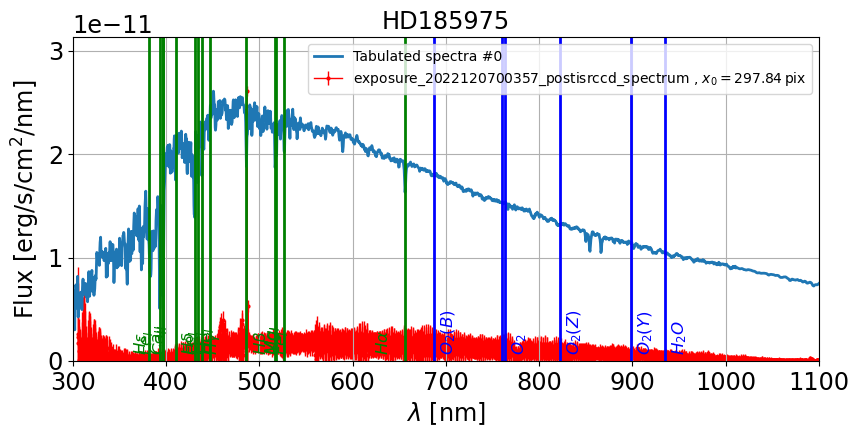

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 1, pagenum = 1/6.0, idx_inpage = 2, idx_fig = 3


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 2, pagenum = 1/6.0, idx_inpage = 3, idx_fig = 5


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 3, pagenum = 1/6.0, idx_inpage = 4, idx_fig = 7


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 4, pagenum = 1/6.0, idx_inpage = 5, idx_fig = 9


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 5, pagenum = 2/6.0, idx_inpage = 1, idx_fig = 1


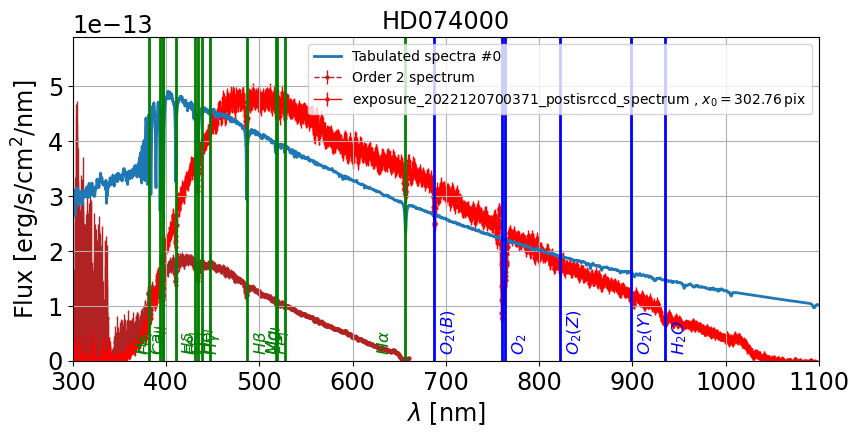

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 6, pagenum = 2/6.0, idx_inpage = 2, idx_fig = 3


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 7, pagenum = 2/6.0, idx_inpage = 3, idx_fig = 5


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 8, pagenum = 2/6.0, idx_inpage = 4, idx_fig = 7


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 9, pagenum = 2/6.0, idx_inpage = 5, idx_fig = 9


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 10, pagenum = 3/6.0, idx_inpage = 1, idx_fig = 1


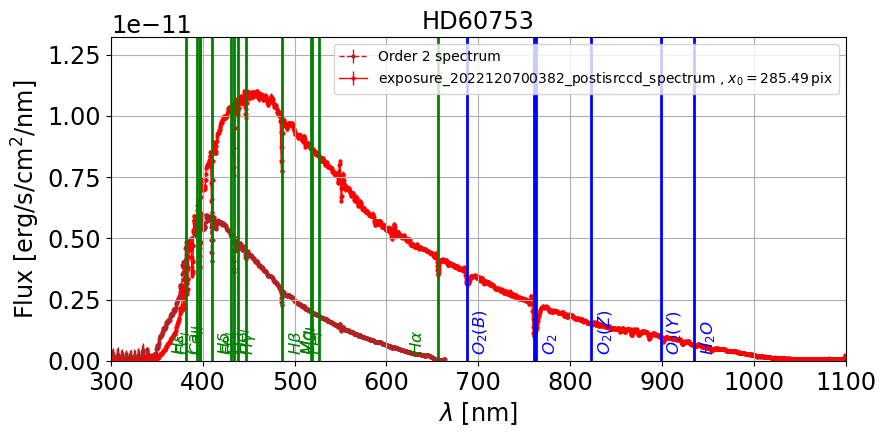

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 11, pagenum = 3/6.0, idx_inpage = 2, idx_fig = 3


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 12, pagenum = 3/6.0, idx_inpage = 3, idx_fig = 5


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 13, pagenum = 3/6.0, idx_inpage = 4, idx_fig = 7


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 14, pagenum = 3/6.0, idx_inpage = 5, idx_fig = 9


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 15, pagenum = 4/6.0, idx_inpage = 1, idx_fig = 1


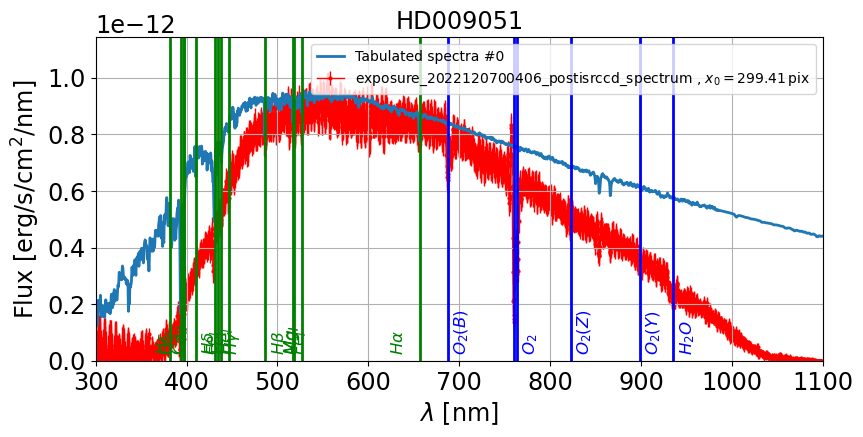

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 16, pagenum = 4/6.0, idx_inpage = 2, idx_fig = 3


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 17, pagenum = 4/6.0, idx_inpage = 3, idx_fig = 5


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 18, pagenum = 4/6.0, idx_inpage = 4, idx_fig = 7


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 19, pagenum = 4/6.0, idx_inpage = 5, idx_fig = 9


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 20, pagenum = 5/6.0, idx_inpage = 1, idx_fig = 1


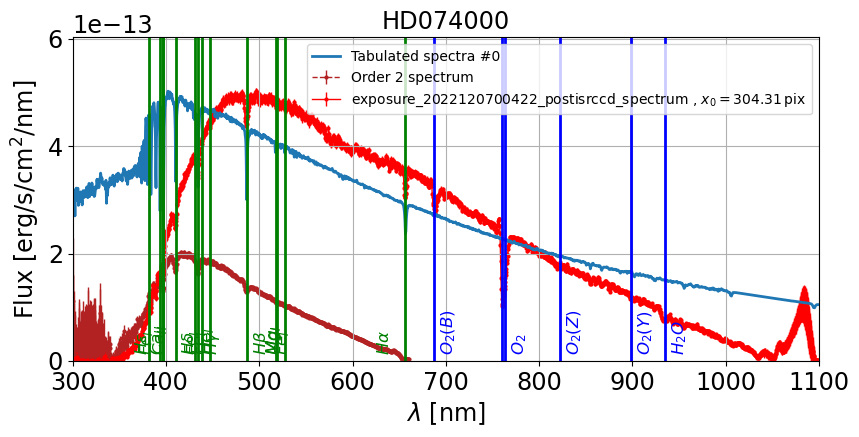

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 21, pagenum = 5/6.0, idx_inpage = 2, idx_fig = 3


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 22, pagenum = 5/6.0, idx_inpage = 3, idx_fig = 5


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 23, pagenum = 5/6.0, idx_inpage = 4, idx_fig = 7


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 24, pagenum = 5/6.0, idx_inpage = 5, idx_fig = 9


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 25, pagenum = 6/6.0, idx_inpage = 1, idx_fig = 1


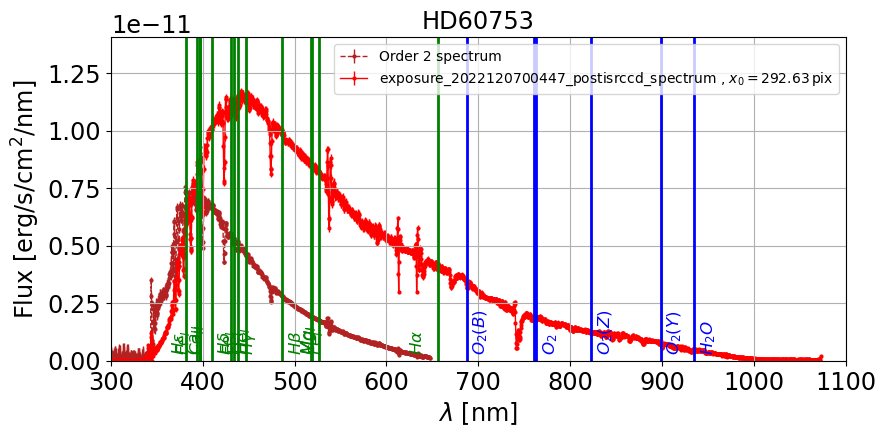

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 26, pagenum = 6/6.0, idx_inpage = 2, idx_fig = 3


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 27, pagenum = 6/6.0, idx_inpage = 3, idx_fig = 5


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 28, pagenum = 6/6.0, idx_inpage = 4, idx_fig = 7


<Figure size 1600x400 with 0 Axes>

	 	  SaveFigSpectraInPdf >>>>>>>>  spec num = 29, pagenum = 6/6.0, idx_inpage = 5, idx_fig = 9


<Figure size 1600x400 with 0 Axes>

In [60]:
all_figs = SaveFigSpectraInPdf(nbspecperpage=5)

### Summary spectra

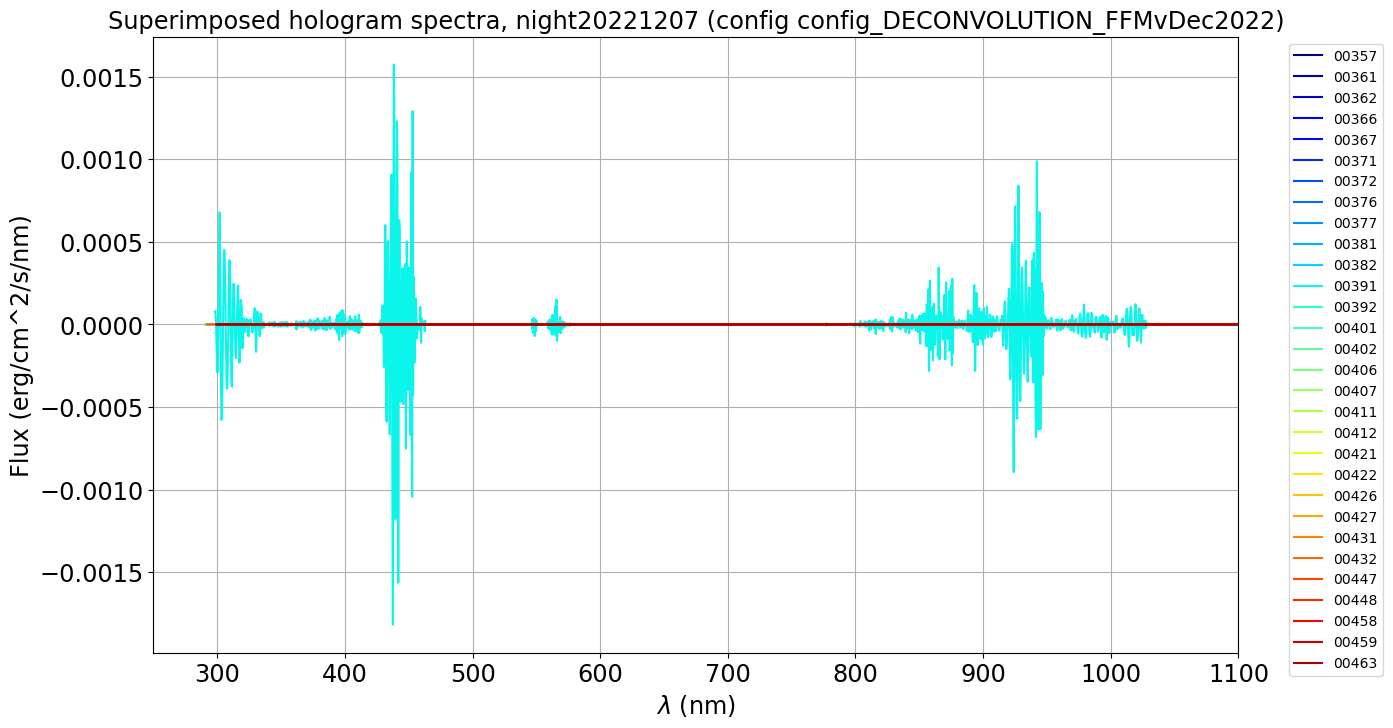

In [61]:
thetitle = f"Superimposed hologram spectra, night{DATE} (config {configdir})"
sumfig = SaveFigSpectraSummaryInPdf(all_lambdas,all_data,all_num,delta=0, thetitle=thetitle)

In [62]:
all_figs.append(sumfig)

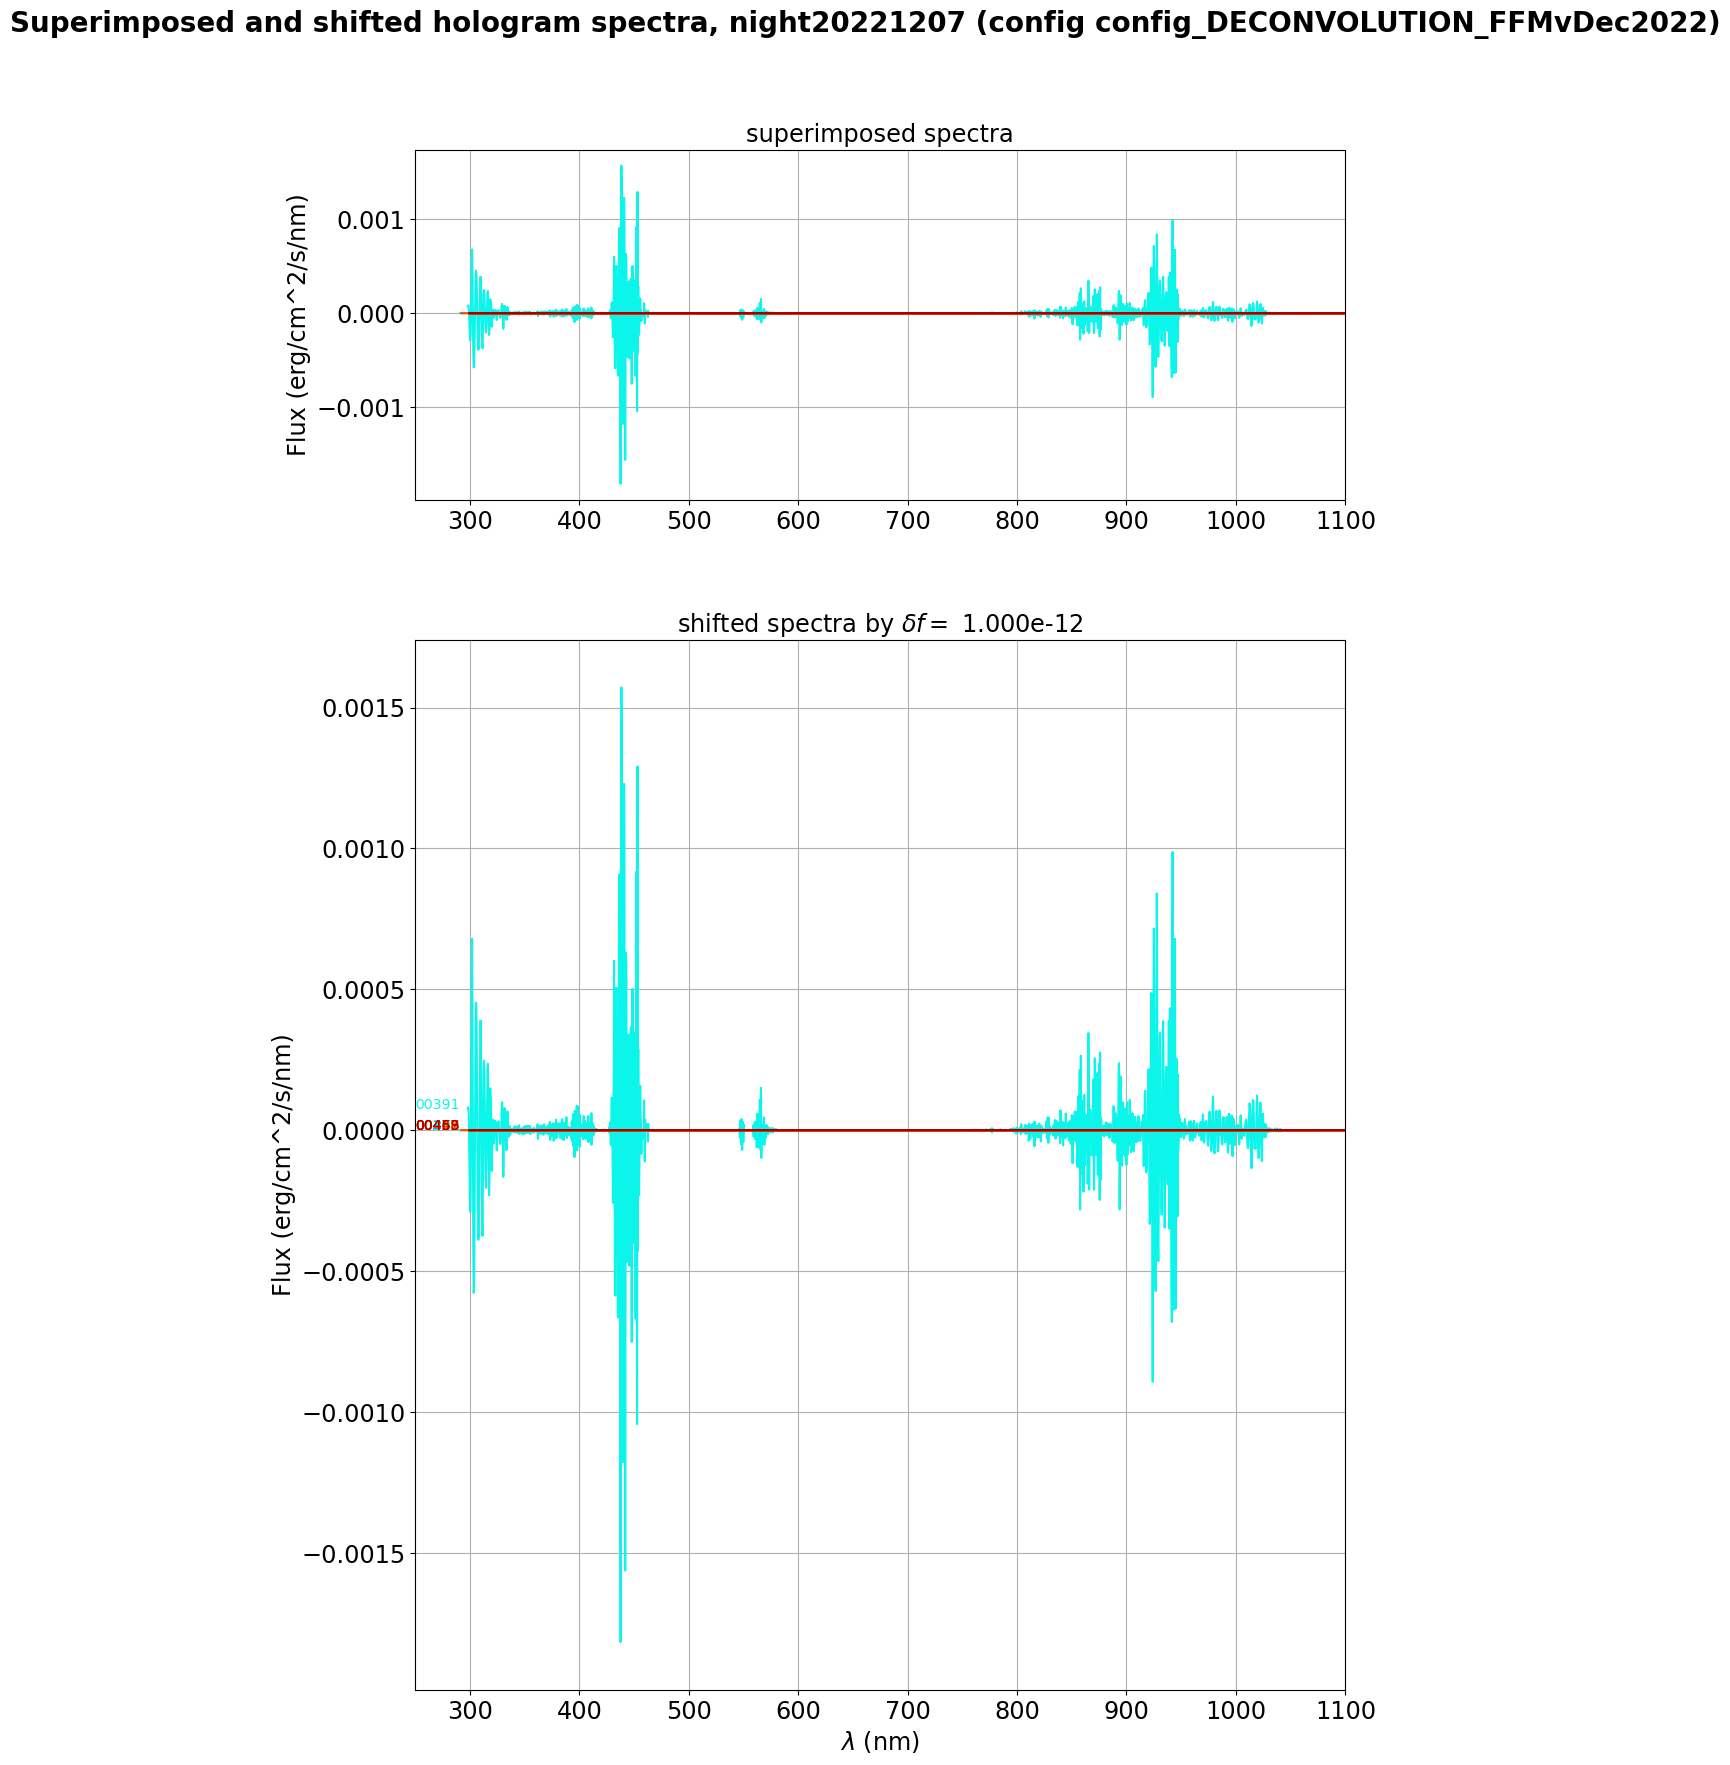

In [63]:
thetitle2 = f"Superimposed and shifted hologram spectra, night{DATE} (config {configdir})"
sumfig2 = SaveFigSpectraSummaryBothInPdf(all_lambdas,all_data,all_num,delta=0.1e-11,thetitle=thetitle2)

In [64]:
all_figs.append(sumfig2)

### Save in pdf file

In [65]:
# Write all images in pdf files

#multipage_pdf_file = f'multipage_pdf_holo_{DATE}_{configdir}.pdf'
# gerate a multipage pdf:
#with PdfPages(multipage_pdf_file) as pdf:
#    for fig in all_figs:
#        pdf.savefig(fig)
#        plt.close()


## View one spectrum

3 ) exposure_2022120700366_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMvDec2022/20221207/2022120700366/basespec/exposure_2022120700366_postisrccd_spectrum.fits


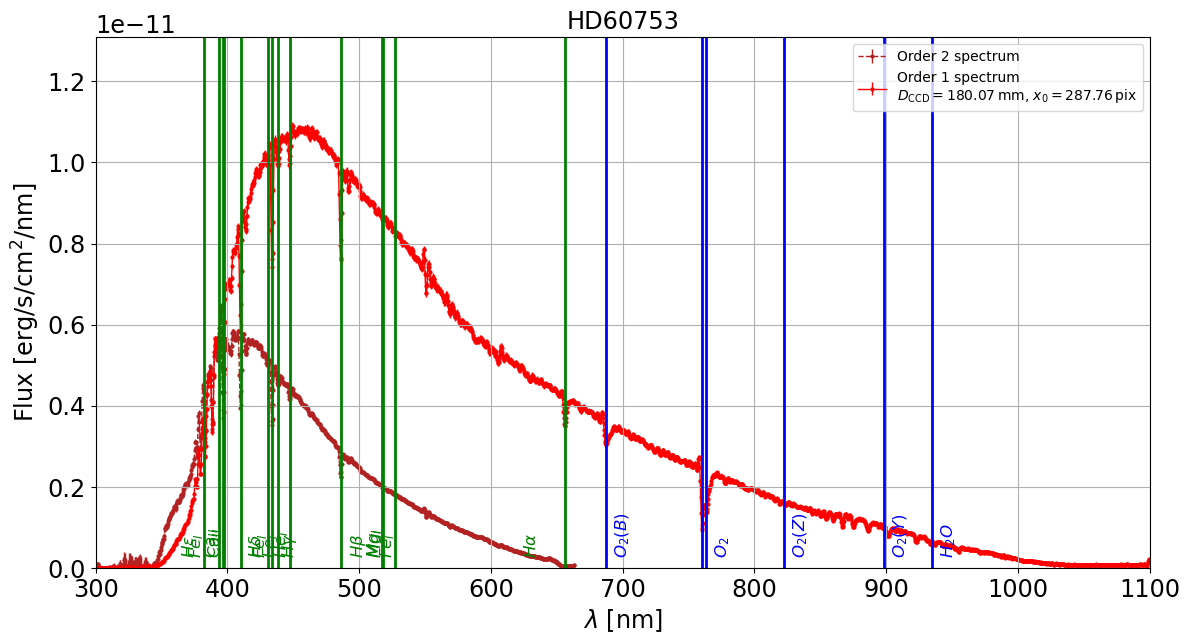

In [66]:
idx=3

fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(2, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])
all_num.append(tag)
    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True)

#ax2 = fig.add_subplot(1, 2, 2)
    
#fullfilename2=all_files_spectrogram[idx]
    
#s.load_spectrogram(fullfilename2)
#s.plot_spectrogram(ax=ax2,scale="log")
    

plt.show()
    
    
    
if FLAG_RECALIB: 
    ax2 = fig.add_subplot(2, 1, 2)
    print(" === RECALIBRATE lines === ")
    s.lines = lines_calib
    lambdas = calibrate_spectrum(s, with_adr=False)
    label=filename.split('.')[0]+" recalibrated"
    s.plot_spectrum(ax=ax2,force_lines=True,label=label)
    t=s.lines.print_detected_lines(print_table=True)
    print(t["Shift"])
    print(t["Chisq"])
        

In [67]:
all_figs.append(fig)

## Info

In [68]:
df_infos=pd.DataFrame(infos,columns=["idx","object","date_obs","airmass","temperature","pressure","humidity"])

In [69]:
df_infos.set_index('idx',inplace=True)

In [70]:
all_reftime=[ (Time(tt)-Time( df_infos["date_obs"].values[0])).to_value(u.hr) for tt in df_infos["date_obs"].values ]

In [71]:
all_reftime=np.array(all_reftime)

In [72]:
df_infos["reftime"]=all_reftime

In [73]:
NN = len(df_infos)

In [74]:
df_infos

object                 date_obs   airmass  temperature  pressure  \
idx                                                                       
0    HD185975  2022-12-08T04:22:10.078  2.062400          7.0     740.0   
1    HD074000  2022-12-08T04:24:49.237  1.728743          7.0     740.0   
2    HD074000  2022-12-08T04:25:32.210  1.722192          7.0     740.0   
3     HD60753  2022-12-08T04:27:51.673  1.241016          7.0     740.0   
4     HD60753  2022-12-08T04:28:34.590  1.239308          7.0     740.0   
5    HD074000  2022-12-08T04:30:51.535  1.675438          7.0     740.0   
6    HD074000  2022-12-08T04:31:34.467  1.669413          7.0     740.0   
7    HD074000  2022-12-08T04:44:19.846  1.570405          7.0     740.0   
8    HD074000  2022-12-08T04:45:02.705  1.565322          7.0     740.0   
9     HD60753  2022-12-08T04:47:23.045  1.198119          7.0     740.0   
10    HD60753  2022-12-08T04:48:05.877  1.196684          7.0     740.0   
11   HD185975  2022-12-08T04:53:05.049  2.080753          7.0     740.0   
12   HD185975  2022-12-08T04:53:47.972  2.081150          7.0     740.0   
13    HD14943  2022-12-08T04:58:58.920  1.283764          7.0     740.0   
14    HD14943  2022-12-08T04:59:41.782  1.285727          7.0     740.0   
15   HD009051  2022-12-08T05:04:16.609  1.643454          7.0     740.0   
16   HD009051  2022-12-08T05:04:59.517  1.649201          7.0     740.0   
17    HD14943  2022-12-08T05:07:10.943  1.307116          7.0     740.0   
18    HD14943  2022-12-08T05:07:53.770  1.309224          7.0     740.0   
19   HD074000  2022-12-08T05:15:11.940  1.385738          7.0     740.0   
20   HD074000  2022-12-08T05:15:54.892  1.382191          7.0     740.0   
21   HD074000  2022-12-08T05:17:42.866  1.373416          7.0     740.0   
22   HD074000  2022-12-08T05:18:25.676  1.369985          7.0     740.0   
23    HD60753  2022-12-08T05:20:50.568  1.140931          7.0     740.0   
24    HD60753  2022-12-08T05:21:33.493  1.139906          7.0     740.0   
25    HD60753  2022-12-08T05:29:36.983  1.128968          7.0     740.0   
26    HD60753  2022-12-08T05:30:19.941  1.128040          7.0     740.0   
27    HD60753  2022-12-08T05:35:53.901  1.121118          7.0     740.0   
28    HD60753  2022-12-08T05:36:36.917  1.120257          7.0     740.0   
29   HD074000  2022-12-08T05:39:04.318  1.281767          7.0     740.0   

     humidity   reftime  
idx                      
0        30.0  0.000000  
1        30.0  0.044211  
2        30.0  0.056148  
3        30.0  0.094888  
4        30.0  0.106809  
5        30.0  0.144849  
6        30.0  0.156775  
7        30.0  0.369380  
8        30.0  0.381285  
9        30.0  0.420269  
10       30.0  0.432166  
11       30.0  0.515270  
12       30.0  0.527193  
13       30.0  0.613567  
14       30.0  0.625473  
15       30.0  0.701814  
16       30.0  0.713733  
17       30.0  0.750240  
18       30.0  0.762137  
19       30.0  0.883851  
20       30.0  0.895782  
21       30.0  0.925774  
22       30.0  0.937666  
23       30.0  0.977914  
24       30.0  0.989838  
25       30.0  1.124140  
26       30.0  1.136073  
27       30.0  1.228840  
28       30.0  1.240789  
29       30.0  1.281733

In [75]:
configmode

'FFMvDec2022'

In [76]:
#summary_file = f"summaryspectra_{DATE}_{configdir}.csv"
summary_file = f"summaryspectra_{DATE}-{filterdispersername}-{configdir}.csv"
df_infos.to_csv(summary_file)

Text(0.5, 1.0, 'airmassvs vs date')

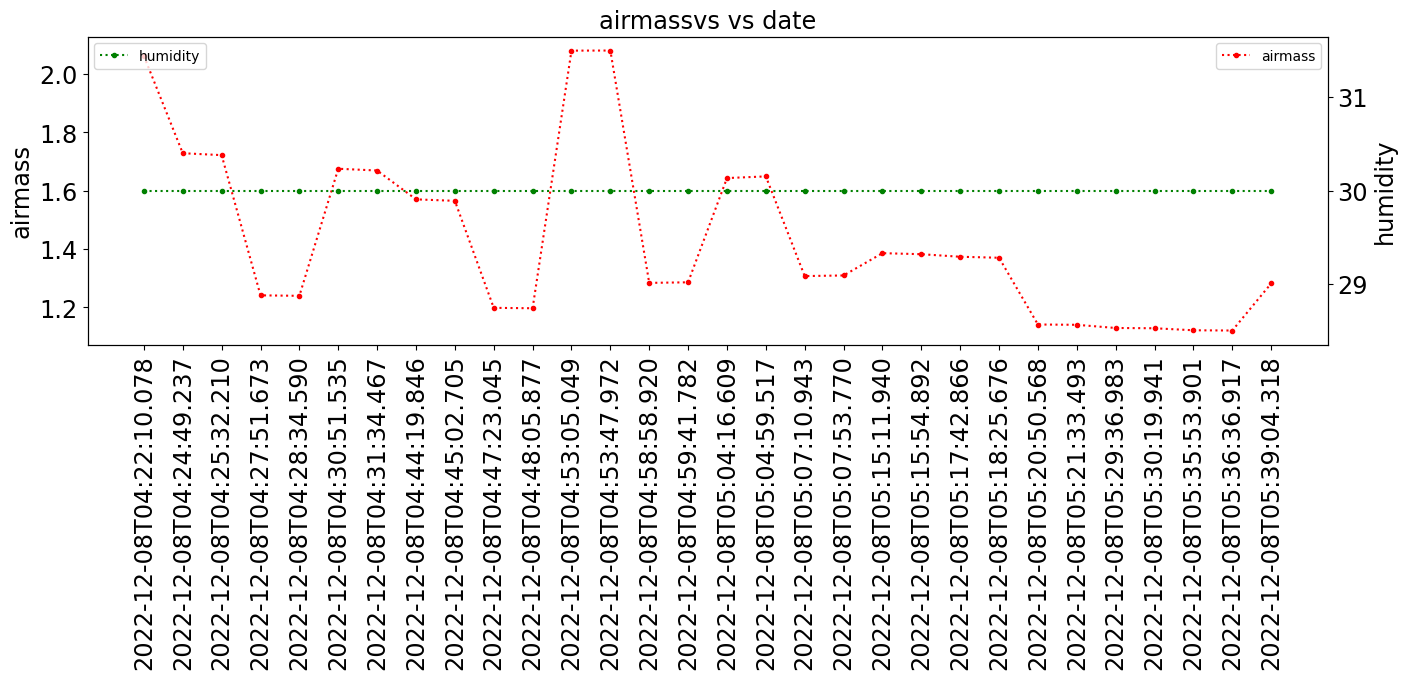

In [77]:
fig=plt.figure(figsize=(16,4))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_infos['date_obs'], df_infos['airmass'],linestyle='dotted', marker='.',color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel("airmass")
ax.legend(loc="upper right")

ax2 = ax.twinx()
ax2.plot(df_infos['date_obs'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.legend(loc="upper left")
ax.set_title("airmassvs vs date")

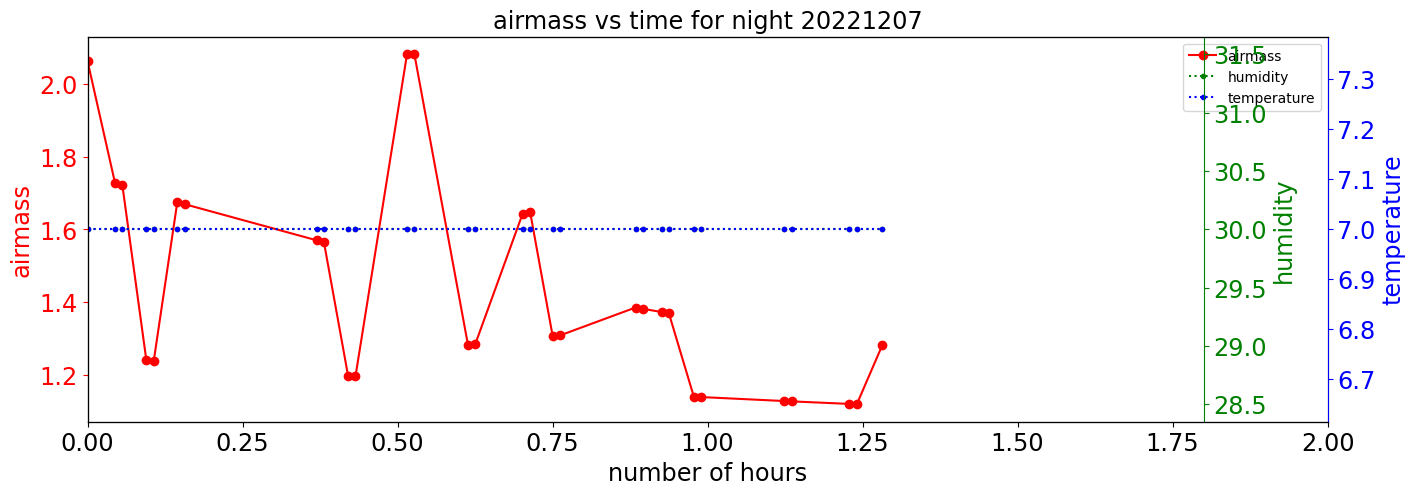

In [78]:
fig=plt.figure(figsize=(16,5))
#plt.xticks(rotation=90)
ax = fig.add_subplot(1, 1, 1)
p1,= ax.plot(df_infos['reftime'], df_infos['airmass'],marker="o",color="red",label="airmass")
#ax.set_xticks(rotation='vertical');
#ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel("number of hours")
ax.set_xlim(0,np.ceil(df_infos['reftime'].values.max()))
ax.set_ylabel("airmass")
ax2 = ax.twinx()
p2, = ax2.plot(df_infos['reftime'], df_infos['humidity'],linestyle='dotted', marker='.',color="green",label="humidity")
ax2.set_ylabel("humidity")
ax2.spines["right"].set_position(("axes", 0.9))

ax3 = ax.twinx()

ax3.spines["right"].set_position(("axes", 1.0))
p3, = ax3.plot(df_infos['reftime'], df_infos['temperature'],linestyle='dotted', marker='.',color="blue",label="temperature")
ax3.set_ylabel("temperature")

curves = [p1, p2, p3]
ax.legend(curves, [c.get_label() for c in curves])

ax.set_title(f"airmass vs time for night {DATE}")

ax.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax3.yaxis.label.set_color(p3.get_color())

ax2.spines["right"].set_edgecolor(p2.get_color())
ax3.spines["right"].set_edgecolor(p3.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())
ax3.tick_params(axis='y', colors=p3.get_color())
plt.show()


In [79]:
all_figs.append(fig)

# Header info

In [80]:
NN=len(all_good_spectra_spectrum_files)

all_rebin=np.zeros(NN)
all_targetx=np.zeros(NN)
all_targety=np.zeros(NN)
all_rotangle=np.zeros(NN)
all_d2ccd=np.zeros(NN)
all_pixshift=np.zeros(NN)
all_chi2_fit=np.zeros(NN)
all_a2_fit=np.zeros(NN)
all_lbda_ref=np.zeros(NN)
all_tagnumber=np.zeros(NN)


for idx in range(NN):
    
    fullfilename=all_good_spectra_spectrum_files[idx]
    
    filename= os.path.basename(fullfilename)
    hdul=fits.open(fullfilename)
    header=hdul[0].header
    tagnum=str(all_num[idx])
    
    #ROTANGLE=  -0.1367006901184345 / [deg] angle of the dispersion axis             
    #D2CCD   =    179.6778868175837 / [mm] distance between disperser and CCD        
    #TARGETX =    315.9547462941386 / target position on X axis                      
    #TARGETY =    75.06785960446246 / target position on Y axis                      
    #LBDA_REF=    634.9155139280113                                                  
    #PIXSHIFT=  -0.9996981508176748                                                  
    #CHI2_FIT=    1.602115867259752                                                  
    #A2_FIT  =                  1.0                                                  
    #REBIN   =                    2 / original image rebinning factor to get spectrum
    
    rebin=header["REBIN"]
    targetx=header["TARGETX"]*rebin
    targety=header["TARGETY"]*rebin
    rotangle=header["ROTANGLE"]
    d2ccd=header["D2CCD"]
    pixshift=header["PIXSHIFT"]
    
    if header.get("CHI2_FIT") != None:
        chi2_fit=header["CHI2_FIT"]
    else:
        chi2_fit= -1
        
    if header.get("A2_FIT") != None:
        a2_fit=header["A2_FIT"]
    else:
        a2_fit=-1
    
    
    lbda_ref=header["LBDA_REF"]
    
    
    all_rebin[idx]=rebin
    all_targetx[idx]=targetx
    all_targety[idx]=targety
    all_rotangle[idx]=rotangle
    all_d2ccd[idx]=d2ccd
    all_pixshift[idx]=pixshift
    
    
    all_chi2_fit[idx]=chi2_fit
    all_a2_fit[idx]=a2_fit
    all_lbda_ref[idx]=lbda_ref
    all_tagnumber[idx]=tagnum
    

In [81]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2291                                                  
NAXIS2  =                    3                                                  
EXTEND  =                    T                                                  
CCD_MANU= 'ITL     '                                                            
CCD_TYPE= '3800C   '                                                            
BINX    =                    1                                                  
BINY    =                    1                                                  
CCDGAIN =                  1.0                                                  
CCDNOISE=                 10.0                                                  
CCDSLOT = 'S00     '        

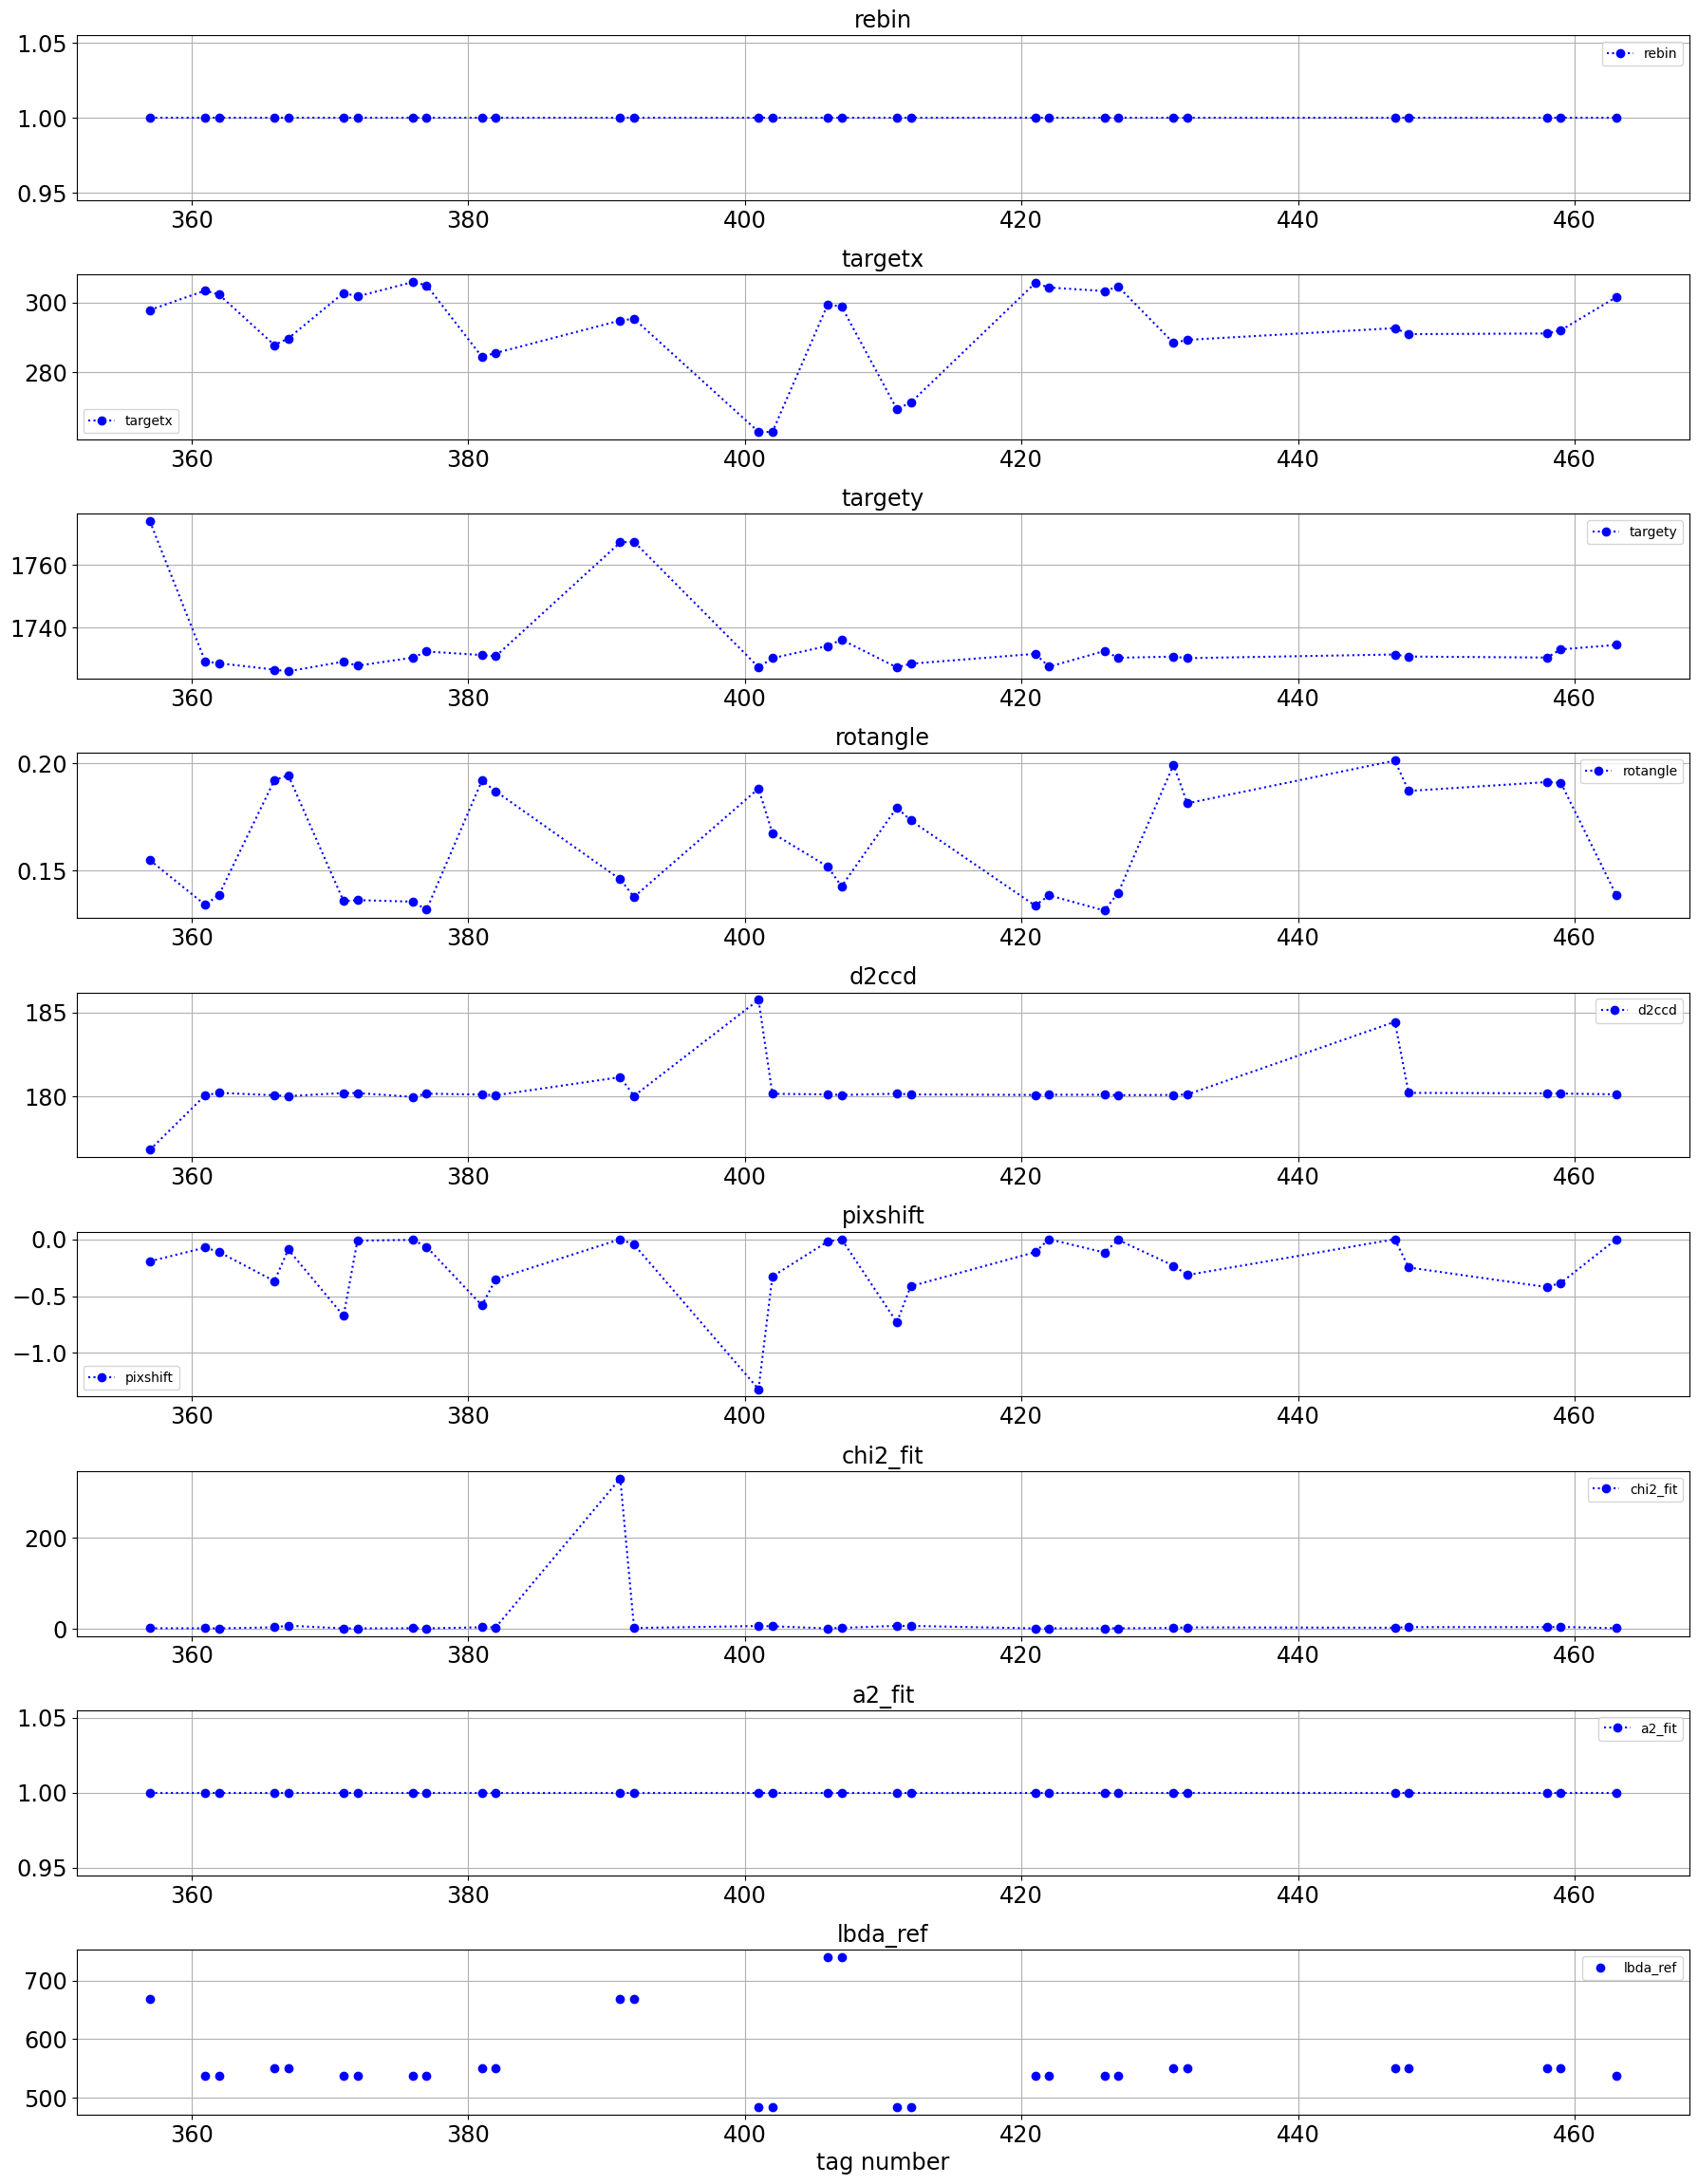

In [82]:
fig=plt.figure(figsize=(18,25))

# rebin
ax=fig.add_subplot(10,1,1)
ax.plot(all_tagnumber,all_rebin,"b:o",label="rebin")
ax.legend()
ax.grid()
ax.set_title("rebin")

#targetx
ax=fig.add_subplot(10,1,2)
ax.plot(all_tagnumber,all_targetx,"b:o",label="targetx")
ax.legend()
ax.grid()
ax.set_title("targetx")



#targety
ax=fig.add_subplot(10,1,3)
ax.plot(all_tagnumber,all_targety,"b:o",label="targety")
ax.legend()
ax.grid()
ax.set_title("targety")



#rotangle
ax=fig.add_subplot(10,1,4)
ax.plot(all_tagnumber,all_rotangle,"b:o",label="rotangle")
ax.legend()
ax.grid()
ax.set_title("rotangle")

#d2ccd
ax=fig.add_subplot(10,1,5)
ax.plot(all_tagnumber,all_d2ccd,"b:o",label="d2ccd")
ax.legend()
ax.grid()
ax.set_title("d2ccd")


#pixshift
ax=fig.add_subplot(10,1,6)
ax.plot(all_tagnumber,all_pixshift,"b:o",label="pixshift")
ax.legend()
ax.grid()
ax.set_title("pixshift")


#chi2_fit
ax=fig.add_subplot(10,1,7)
ax.plot(all_tagnumber,all_chi2_fit,"b:o",label="chi2_fit")
ax.legend()
ax.grid()
ax.set_title("chi2_fit")

#a2_fit
ax=fig.add_subplot(10,1,8)
ax.plot(all_tagnumber,all_a2_fit,"b:o",label="a2_fit")
ax.legend()
ax.grid()
ax.set_title("a2_fit")


#all_lbda_ref
ax=fig.add_subplot(10,1,9)
ax.plot(all_tagnumber,all_lbda_ref,"bo",label="lbda_ref")
ax.legend()
ax.grid()
ax.set_title("lbda_ref")

ax.set_xlabel("tag number")
plt.tight_layout()
plt.show()


In [83]:
all_figs.append(fig)

# Write in pdf file

In [84]:
# Write all images in pdf files
if FLAG_RECALIB:  
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}_recalib.pdf'
else:
    multipage_pdf_file = f'multipage_pdf_holo-{DATE}-{filterdispersername}-{configdir}.pdf'
    
# gerate a multipage pdf:
with PdfPages(multipage_pdf_file) as pdf:
    for fig in all_figs:
        pdf.savefig(fig)
        plt.close()

In [85]:
 multipage_pdf_file

'multipage_pdf_holo-20221207-empty~holo4_003-config_DECONVOLUTION_FFMvDec2022.pdf'

# write in pickles files

In [86]:
all_out_data = {}

for idx in range(NN):
    if FLAG_ORDER2:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'], 
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
               'all_lambdas_order2':all_lambdas_order2[idx],
               'all_fluxes_order2':all_data_order2[idx],
               'all_fluxes_err_order2':all_data_err_order2[idx],
              }
    else:
        thedata = {'number':all_tagnumber[idx],
               'object':df_infos.iloc[idx]['object'],
               'dateobs':df_infos.iloc[idx]['date_obs'],
               'refhour':df_infos.iloc[idx]['reftime'],
               'airmass':df_infos.iloc[idx]['airmass'],
               'pressure':df_infos.iloc[idx]['pressure'], 
               'temperature':df_infos.iloc[idx]['temperature'], 
               'humidity':df_infos.iloc[idx]['humidity'], 
               'targetx_pix':all_targetx[idx],
               'targety_pix':all_targety[idx],
               'rotangle':all_rotangle[idx],
               'd2ccd':all_d2ccd[idx],
               'all_lambdas':all_lambdas[idx],
               'all_fluxes':all_data[idx],
               'all_fluxes_err':all_data_err[idx],
            }         
            
    all_out_data[os.path.basename(all_good_spectra_spectrum_files[idx])]=thedata


In [87]:
if FLAG_RECALIB: 
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}_recalib.pickle'
else:
    pkl_outfilename=f'run-auxtel-holo-{DATE}-{filterdispersername}-{configdir}.pickle'
    

with open(pkl_outfilename, 'wb') as pickle_file:
    pickle.dump(all_out_data,pickle_file)


In [88]:
pkl_infilename=pkl_outfilename

In [89]:
with open(pkl_infilename, 'rb') as pickle_file:
    content = pickle.load(pickle_file)


In [90]:
#content

In [91]:
# Get first value of dictionary
next(iter(content.items()))

('exposure_2022120700357_postisrccd_spectrum.fits',
 {'number': 357.0,
  'object': 'HD185975',
  'dateobs': '2022-12-08T04:22:10.078',
  'refhour': 0.0,
  'airmass': 2.062400487395963,
  'pressure': 740.0,
  'temperature': 7.0,
  'humidity': 30.0,
  'targetx_pix': 297.8381988943274,
  'targety_pix': 1773.746595616584,
  'rotangle': 0.1547533279805738,
  'd2ccd': 176.8183491419435,
  'all_lambdas': array([ 305.42881756,  305.78931568,  306.1498144 , ..., 1117.78574722,
         1118.13200164, 1118.47824603]),
  'all_fluxes': array([ 2.61295531e-12,  2.31766072e-12,  1.74032265e-12, ...,
         -6.17854149e-14,  1.33841982e-14,  4.37803483e-14]),
  'all_fluxes_err': array([6.44173336e-12, 5.24854482e-12, 3.85859128e-12, ...,
         1.90139870e-13, 1.83348620e-13, 1.58755336e-13])})